<a href="https://colab.research.google.com/github/davidmertenjones/Thinkful_DSB_Unit_7/blob/master/MovieLens_Capstone_100k_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MovieLens 100k - Recommender Systems

Recommendation algorithms are everywhere on the modern web. From the results of a Google search to Facebook's "People You May Know" to YouTube's "Up Next" playlist to personalized book recommendations on Goodreads, different forms of recommendation algorithms are at work behind the scenes. Often, recommendations are provided using a process called collaborative filtering. Collaborative filtering models provide predictions of user ratings of items based on ratings given to those items by similar users, although how they determine that "similarity" depends on the type of model.

One category of these models, called a "memory-based" system, employs cosine similarity or Pearson correlation to compare user-user or item-item pairs in a vector space. For instance, if two users have provided similar ratings for a mostly-overlapping set of items, their ratings for the items they have not yet reviewed may be predicted by looking at the other user's list. This type of system has the advantage of easy interpretability, but its performance is less impressive with sparse data sets, as there is often less direct overlap between any given pair of users or items.

Other types of models use different measures of similarity. One of the most common alternatives that works well for large datasets is matrix factorization, which is a form of shallow neural network. This system works by generating a number of embeddings (or "factors")for each user and for each item, then predicting the rating that user would assign to that item by taking the dot product of the user-item pair's embeddings. The weight of each factor starts out as random noise, but is updated through use of a loss function and back-propagation to train the neural network on existing user-item pairs' ratings. After a few epochs, the ratings predicted for the training data get much closer to the ground truth values for the data, and the model can now provide predicted ratings for items the user has not reviewed.

The MovieLense 100k dataset is a set of user ratings for movies that was collected by [GroupLens](https://grouplens.org/about/what-is-grouplens/) at the University of Minnesota, Twin Cities in 1998. It contains 100,000 user-movie pairs with star rating data (1-5), as well as time information and demographic information about the users.

This dataset has proven popular as a practice set for building recommenation algorithms, and for benchmarking existing algorithms. Here, we'll be taking a look at a few different types of algorithms, and seeing which one works best for predicting ratings that users would give movies. As this dataset is very sparse, we'll be focusing on matrix factorization-based approaches rather than memory-based approaches. We'll also try out some other techniques, including a basic deep neural network model, as well as various forms of regression (and one classifier).

Our hypothetical use-case for the best model we are able to construct here would be a movie recommender system for a streaming service. We are seeking to minimize the error in prediction rate. In addition to comparing models to one another, we will also reference the benchmarks from [librec.net](https://www.librec.net/release/v1.3/example.html). These benchmarks are presented in root mean-squared error, which assigns a higher penalty to predicted scores that deviate more from ground truth values.

### Project Overview

* Exploratory Analysis
  * Rating Distributions
  * Rating Counts, Means, and Correlations
      * by User
      * by Movie
  * Most Popular Movies
  * Highest-Rated Movies
  * Genre Visualizations
* Feature Engineering for Supervised Models
  * Preventing Ground Truth Leakage
* Supervised Learning Models
    * Multinomial Logistic Regression (*as star rating classifier*)
    * Linear Regression
    * Random Forest Regression
* Matrix Factorization Models
  * fast.ai "CollabLearner" Model
  * Keras Dot Product Model
  * Keras Dot Product Model with Bias Terms
* Keras Deep Learning Model
* Plan for Implementation

### Description (from the MovieLens README file):

u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   

u.info     -- The number of users, items, and ratings in the u data set.

u.item     -- Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.

u.genre    -- A list of the genres.

u.user     -- Demographic information about the users; this is a tab
              separated list of
              user id | age | gender | occupation | zip code.
              The user ids are the ones used in the u.data data set.

**A note on selective data use:**

Although user demographic information and timestamp information are available to us, we'll be ignoring them for now, as we really want to focus on the user-item pair and rating information to build a robust model that could be generalized to different kinds of businesses. However, we will be making use of the movie genre information for a few of our models , as any recommendation algorithm out in the wild would likely have some form of categorization for the items the users are reviewing.

## Module Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats

from fastai.collab import *
from fastai.callbacks import *

import keras
from IPython.display import SVG
from keras.optimizers import adam 
from keras.utils.vis_utils import model_to_dot

import tensorflow as tf

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)


Using TensorFlow backend.


In [0]:
path_string = '/content/drive/Colab Notebooks/ml-100k/{}'

## Mount Google Drive

We're working in Google Colab, which lets us load data directly from Google Drive! This gives our project greater portability between systems. In order to do this, we first have to run this block of code to authorize Google Cloud SDK's access to Drive:

In [0]:
# Code for Google Drive courtesy of Vishakha Lall (see Sources section)

try:
  genre = pd.read_csv(path_string.format('u.genre'), delimiter='|',
                    names=['genre', 'encoding'])
except FileNotFoundError:
  !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
  !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
  !apt-get update -qq 2>&1 > /dev/null
  !apt-get -y install -qq google-drive-ocamlfuse fuse


  from google.colab import auth
  auth.authenticate_user()
  from oauth2client.client import GoogleCredentials
  creds = GoogleCredentials.get_application_default()
  import getpass
  !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
  vcode = getpass.getpass()
  !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

  !mkdir -p drive
  !google-drive-ocamlfuse drive

In [4]:
!ls '/content/drive/Colab Notebooks/ml-100k/'

allbut.pl	    keras_model4.png	    u1.test  u5.base  u.genre
df_supervised.csv   keras_network_bias.png  u2.base  u5.test  u.info
fai_gridsearch.csv  mku.sh		    u2.test  ua.base  u.item
features_super.csv  README		    u3.base  ua.test  u.occupation
keras_model1.png    rfr_grid.csv	    u3.test  ub.base  u.user
keras_model2.png    rfr_gridsearch.csv	    u4.base  ub.test
keras_model3.png    u1.base		    u4.test  u.data


## Data Import

There are several subsets of data within the ml100k set; we will be using u.data (user-movie pairs with rating and timestamp data), u.item (more information about each movie, including an n-hot-encoded matrix for genre), and u.genre (a key to the movie genres). User demographic information is available in u.user and u.occupation, but we are ignoring that for purposes of the following models.

#### Genre

First, let's read in the u.genre file, which contains labels corresponding to the numbered genres in our u.item file.

In [0]:
genre = pd.read_csv(path_string.format('u.genre'), delimiter='|',
                    names=['genre', 'encoding'])

In [6]:
genrelist = genre['genre'].values.tolist()
genrelist

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [0]:
itemcolumns = ['movieId', 'title', 'release',
               'vid_release', 'imdb_url'] + genrelist

#### Movies (with n-hot encoded genre)

This is an older dataset, so it doesn't use UTF-8 encoding. The genres are numeric values, so we'll replace them with the list from u.genre. Movies can be in more than one genre category.



In [0]:
items = pd.read_csv(path_string.format('u.item'), delimiter='|',
                    names=itemcolumns,
                    encoding='latin-1')

items = items.drop(['vid_release', 'imdb_url'], 1)

In [9]:
items.head()

,movieId,title,release,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


#### Ratings (User-Movie pairs with rating)

This is *technically* the only dataset we need to build a recommender algorithm using matrix factorization, but it helps to have at least the title of a movie to go with its ID number.



In [0]:
ratings = pd.read_csv(path_string.format('u.data'), delimiter='\t',
                      names=['userId', 'movieId', 'rating', 'timestamp'])

In [11]:
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
# Convert strings to floats:

ratings['rating'] = ratings['rating'].apply(lambda x: float(x))

# EDA

Before we begin modeling, we need to visualize our dataset, and see what it's made up of.

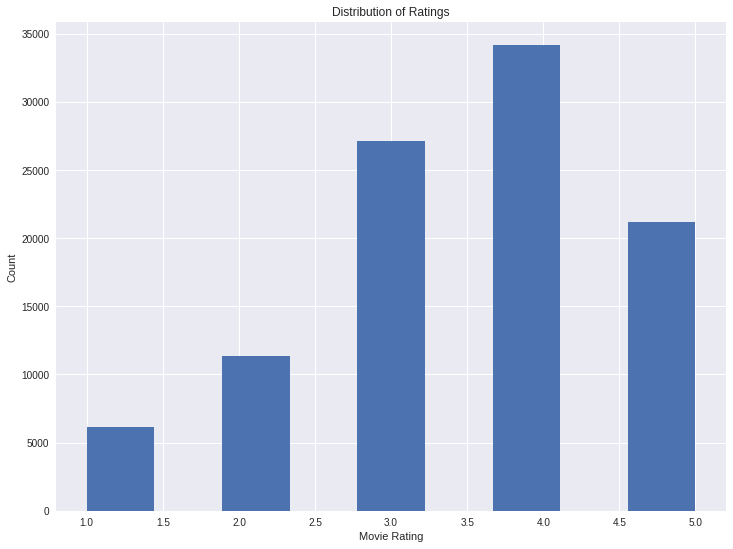

In [13]:
# Distribution of all ratings for user-movie pairs:

plt.rcParams['figure.figsize'] = 12, 9

plt.title('Distribution of Ratings')
plt.hist(ratings.rating, bins=9)
plt.xlabel('Movie Rating')
plt.ylabel('Count')
plt.show()

In [14]:
ratings.rating.describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

This distribution shows some left skewness. The mean movie rating (3.53) is higher than the central possible score (3.0). Let's see if this is a general trend, or the result of a minority of movies or users.

## Rating Counts and Means

By comparing the rating counts and rating means of all users and of all movies separately, we can start to get a more detailed look at user behavior, and at movie popularity. Do users who give ratings to many movies tend to give higher or lower scores on average? Do more widely reviewed movies tend to score higher or lower ratings?

In [0]:
# Function for Regression Plots showing R-squared value

def R_coeff(x, y):
    """Returns rounded Pearson correlation coefficient for two variables."""
    rcoeff = stats.pearsonr(x, y)
    return str(np.round(rcoeff[0], 4))

#### Users

First we'll look at the number of movies reviewed per user, then the mean rating given to all movies per user, and then we'll compare those to see if there's a correlation between the two.

In [16]:
# Get number of movies each user has reviewed.

user_rating_count = ratings.groupby('userId')['rating'].count()

user_rating_count = pd.DataFrame(user_rating_count).reset_index()
user_rating_count.rename(columns={'rating': 'user_count'}, inplace=True)

user_rating_count.head()


,userId,user_count
0,1,272
1,2,62
2,3,54
3,4,24
4,5,175


In [17]:
# Get mean rating user has given to all movies they have reviewed.

user_rating_mean = ratings.groupby('userId')['rating'].mean()

user_rating_mean = pd.DataFrame(user_rating_mean).reset_index()
user_rating_mean.rename(columns={'rating': 'user_mean'}, inplace=True)

user_rating_mean.head()

,userId,user_mean
0,1,3.610294
1,2,3.709677
2,3,2.796296
3,4,4.333333
4,5,2.874286


In [18]:
user_rating_stats = pd.merge(user_rating_count, user_rating_mean, on='userId')
user_rating_stats.head()

,userId,user_count,user_mean
0,1,272,3.610294
1,2,62,3.709677
2,3,54,2.796296
3,4,24,4.333333
4,5,175,2.874286


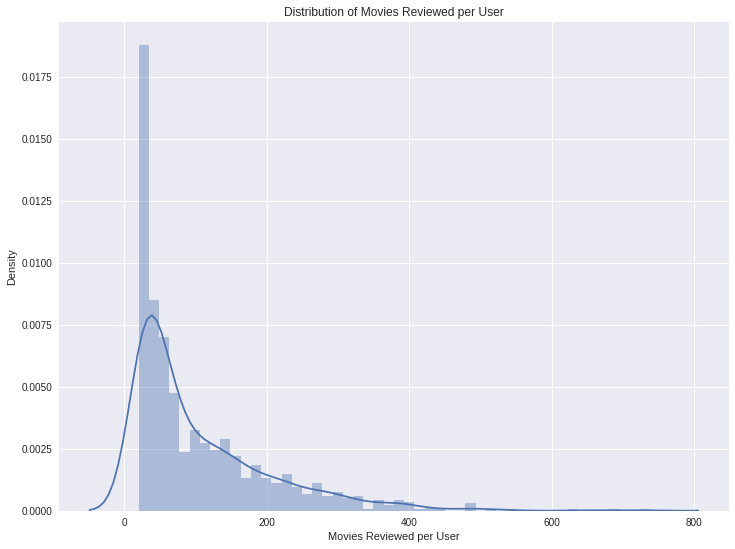

In [19]:
sns.distplot(user_rating_stats['user_count'], bins=50)
plt.title('Distribution of Movies Reviewed per User')
plt.xlabel('Movies Reviewed per User')
plt.ylabel('Density')
plt.show()

The number of movies reviewed per user is heavily weighted towards lower counts.

In [20]:
user_rating_stats['user_count'].describe()

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: user_count, dtype: float64

In [21]:
user_rating_stats['user_count'].median()

65.0

Half of the users in the dataset have reviewed 106 or fewer films. The median is 65 films reviewed (roughly 3.9% of the possible movies). The user who has reviewed the most films still has only reviewed 737/1682 (43.8% of the films in the set).

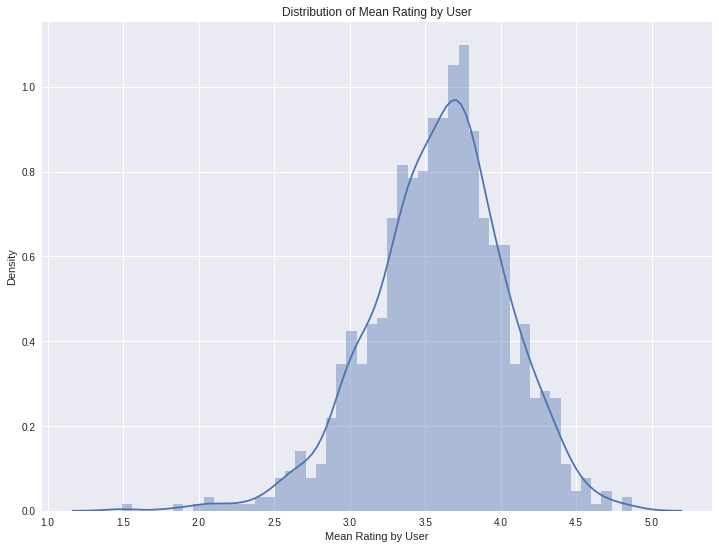

In [22]:
sns.distplot(user_rating_stats['user_mean'], bins=50)
plt.title('Distribution of Mean Rating by User')
plt.xlabel('Mean Rating by User')
plt.ylabel('Density')
plt.show()

In [23]:
user_rating_stats['user_mean'].describe()

count    943.000000
mean       3.588191
std        0.445233
min        1.491954
25%        3.323054
50%        3.620690
75%        3.869565
max        4.869565
Name: user_mean, dtype: float64

In [24]:
user_rating_stats['user_mean'].median()

3.6206896551724137

This is pretty close to the mean score for all movies.

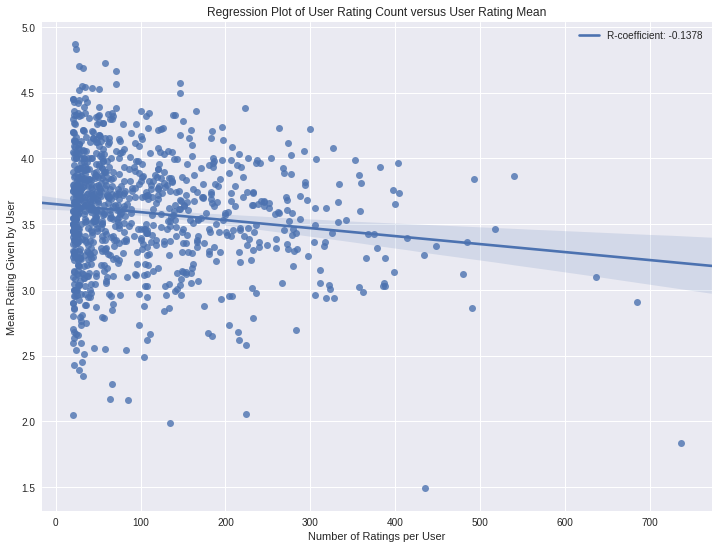

In [25]:
sns.regplot(user_rating_stats['user_count'], user_rating_stats['user_mean'])
plt.title('Regression Plot of User Rating Count versus User Rating Mean')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Mean Rating Given by User')
plt.legend(['R-coefficient: '+R_coeff(user_rating_stats['user_count'],
                                   user_rating_stats['user_mean'])])
plt.show()

In [26]:
stats.pearsonr(user_rating_stats['user_count'], user_rating_stats['user_mean'])

(-0.13779508142960803, 2.1751265996099447e-05)

There is a slight negative correlation between the number of movies a user has reviewed and their average rating for a movie. There could be a number of explanations for this; perhaps users who have watched more movies aren't as easily impressed. Another possibility is that some users just don't bother to rate movies they don't like.

#### Movies

As with Users, we'll be comparing the counts and means after viewing each by itself.


In [27]:
# Get number of reviews provided for each movie.

movie_rating_count = ratings.groupby('movieId')['rating'].count()

movie_rating_count = pd.DataFrame(movie_rating_count).reset_index()
movie_rating_count.rename(columns={'rating': 'movie_count'}, inplace=True)

movie_rating_count.head()

,movieId,movie_count
0,1,452
1,2,131
2,3,90
3,4,209
4,5,86


In [28]:
movie_rating_mean = ratings.groupby('movieId')['rating'].mean()

movie_rating_mean = pd.DataFrame(movie_rating_mean).reset_index()
movie_rating_mean.rename(columns={'rating': 'movie_mean'}, inplace=True)

movie_rating_mean.head()

,movieId,movie_mean
0,1,3.878319
1,2,3.206107
2,3,3.033333
3,4,3.550239
4,5,3.302326


In [29]:
movie_rating_stats = pd.merge(movie_rating_count, movie_rating_mean, on='movieId')
movie_rating_stats.head()

,movieId,movie_count,movie_mean
0,1,452,3.878319
1,2,131,3.206107
2,3,90,3.033333
3,4,209,3.550239
4,5,86,3.302326


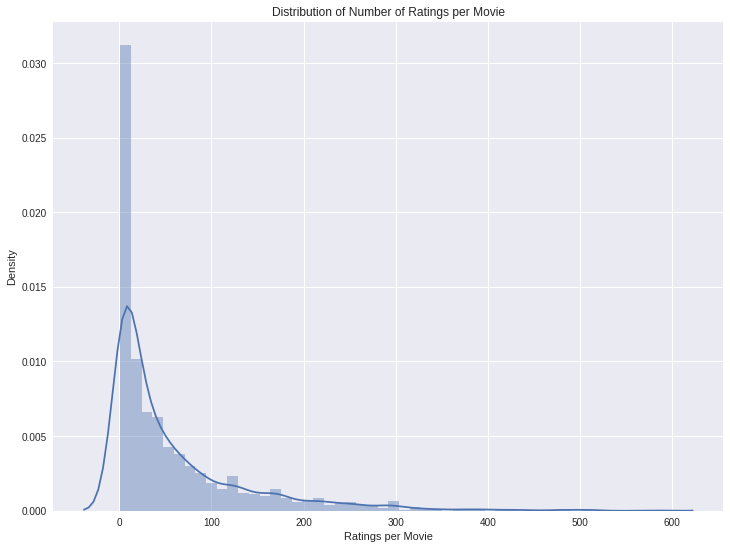

In [30]:
sns.distplot(movie_rating_stats['movie_count'], bins=50)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Ratings per Movie')
plt.ylabel('Density')
plt.show()

In [31]:
movie_rating_stats['movie_count'].describe()

count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: movie_count, dtype: float64

In [32]:
movie_rating_stats['movie_count'].median()

27.0

Unlike users (who are only included in the dataset if they have reviewed 20 or more films), there is no minimum threshold for inclusion for movies. The median here is 27 ratings (2.9% of users have seen the film), but the maximum number of ratings is 583 (61.8% of users having seen the film.)

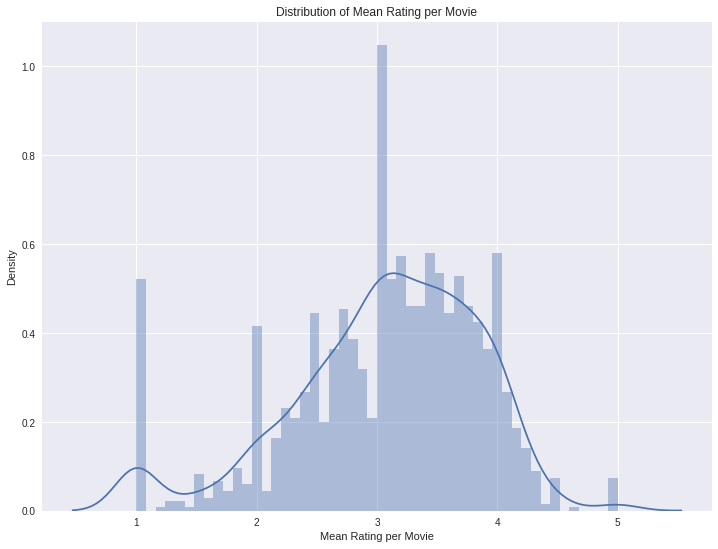

In [33]:
sns.distplot(movie_rating_stats['movie_mean'], bins=50)
plt.title('Distribution of Mean Rating per Movie')
plt.xlabel('Mean Rating per Movie')
plt.ylabel('Density')
plt.show()

In [34]:
movie_rating_stats['movie_mean'].describe()

count    1682.000000
mean        3.076045
std         0.781662
min         1.000000
25%         2.659600
50%         3.161528
75%         3.653428
max         5.000000
Name: movie_mean, dtype: float64

In [35]:
movie_rating_stats['movie_mean'].median()

3.1615275142314987

Unusual distribution of mean point scores near whole number values are due to movies in the dataset that only have a few ratings.

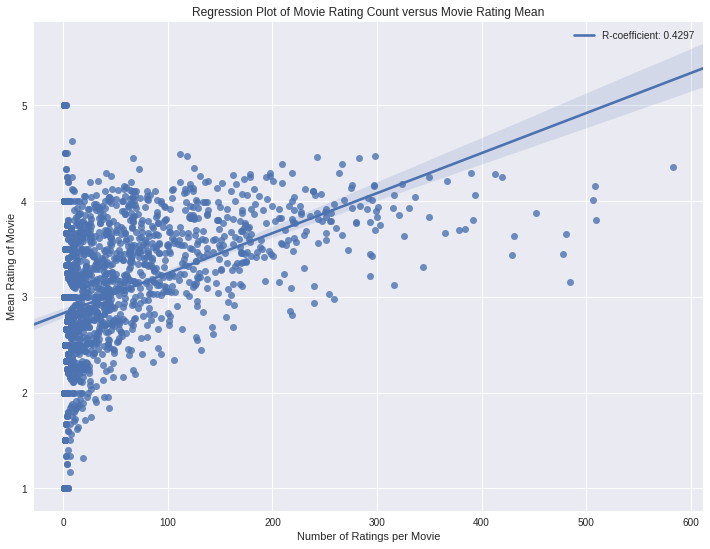

In [36]:
sns.regplot(movie_rating_stats['movie_count'], movie_rating_stats['movie_mean'])
plt.title('Regression Plot of Movie Rating Count versus Movie Rating Mean')
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Mean Rating of Movie')
plt.legend(['R-coefficient: '+R_coeff(movie_rating_stats['movie_count'],
                                      movie_rating_stats['movie_mean'])])
plt.show()

In [37]:
stats.pearsonr(movie_rating_stats['movie_count'], movie_rating_stats['movie_mean'])

(0.4296591698676232, 1.5967054836586385e-76)

There is a moderate positive correlation between the number of ratings a movie has and its mean rating. Better movies tend to be more popular, while movies with fewer ratings (and likely fewer views) are more likely to have ratings that span the extremes of 1 and 5 points.

In [38]:
df_merged = pd.merge(ratings.drop(['timestamp'], 1),
                     items[['movieId', 'title']], on='movieId')

df_merged = pd.merge(df_merged, user_rating_stats, on='userId')

df_merged = pd.merge(df_merged, movie_rating_stats, on='movieId')

df_merged.head()

,userId,movieId,rating,title,user_count,user_mean,movie_count,movie_mean
0,196,242,3.0,Kolya (1996),39,3.615385,117,3.991453
1,63,242,3.0,Kolya (1996),93,3.118280,117,3.991453
2,226,242,5.0,Kolya (1996),50,3.800000,117,3.991453
3,154,242,3.0,Kolya (1996),51,3.960784,117,3.991453
4,306,242,5.0,Kolya (1996),32,3.781250,117,3.991453


## Most Popular Movies

This chart shows the title, mean rating, mean user_count (mean of the number of films each user who rated this movie has rated), mean user_mean (mean of the mean rating users who have rated the film have given to all films they have rated), and movie_count (number of users who rated the movie). The entries are ordered by movie_count, descending.

In [39]:
df_merged.drop(['userId', 'movieId', 'movie_mean'], 1).groupby('title').mean().sort_values(by='movie_count',
                                                      ascending=False).head(20)

,rating,user_count,user_mean,movie_count
title,,,,
Star Wars (1977),4.358491,140.624357,3.608816,583.0
Contact (1997),3.803536,119.418468,3.531827,509.0
Fargo (1996),4.155512,142.080709,3.600765,508.0
Return of the Jedi (1983),4.007890,148.802761,3.583099,507.0
Liar Liar (1997),3.156701,119.292784,3.525744,485.0
"English Patient, The (1996)",3.656965,109.195426,3.568388,481.0
Scream (1996),3.441423,119.707113,3.524495,478.0
Toy Story (1995),3.878319,146.424779,3.579055,452.0
Air Force One (1997),3.631090,106.549884,3.522442,431.0


## Highest-Rated Movies

Same categories as most popular movies, ranked by mean rating, descending:

In [40]:
df_merged.drop(['userId', 'movieId', 'movie_mean'],1).groupby('title').mean().sort_values(by='rating',
                                                      ascending=False).head(20)

,rating,user_count,user_mean,movie_count
title,,,,
They Made Me a Criminal (1939),5.000000,208.000000,4.086538,1.0
Marlene Dietrich: Shadow and Light (1996),5.000000,300.000000,4.223333,1.0
"Saint of Fort Washington, The (1993)",5.000000,239.000000,3.506880,2.0
Someone Else's America (1995),5.000000,263.000000,3.581749,1.0
Star Kid (1997),5.000000,62.333333,3.822636,3.0
"Great Day in Harlem, A (1994)",5.000000,636.000000,3.097484,1.0
Aiqing wansui (1994),5.000000,281.000000,3.295374,1.0
Santa with Muscles (1996),5.000000,238.000000,3.526498,2.0
Prefontaine (1997),5.000000,326.000000,3.919250,3.0


 Here, we are likely seeing some bias due to small sample size. This so-called "cold start" problem presents an obstacle for building effective recommendation algorithms; when a user or an item has only a tiny number of associated ratings, it's hard to reliably predict the rating.

However, we will keep these in the dataset because there is still substantial user information paired with the movies with low counts (the user who rated "Entertaining Angels" has only rated 34 films, but most of the users who have rated these less-popular films have a high mean user_count, meaning that they have on average rated hundreds of movies.)

## Breakdown by Genre

In [0]:
# Sort genres by larges proportion of dataset

g_proport = pd.DataFrame()
proportions = []

for genre in genrelist:
  proportion = np.round(100 * (len(items[items[genre] == 1])/ len(items)), 2)
  proportions.append(float(proportion))
  
g_proport['genre'] = genrelist
g_proport['proportions'] = proportions
g_proport['prop_string'] = g_proport['proportions'].apply(lambda x: str(np.round(x, 2)))

g_proport = g_proport.sort_values(by='proportions', ascending=False)

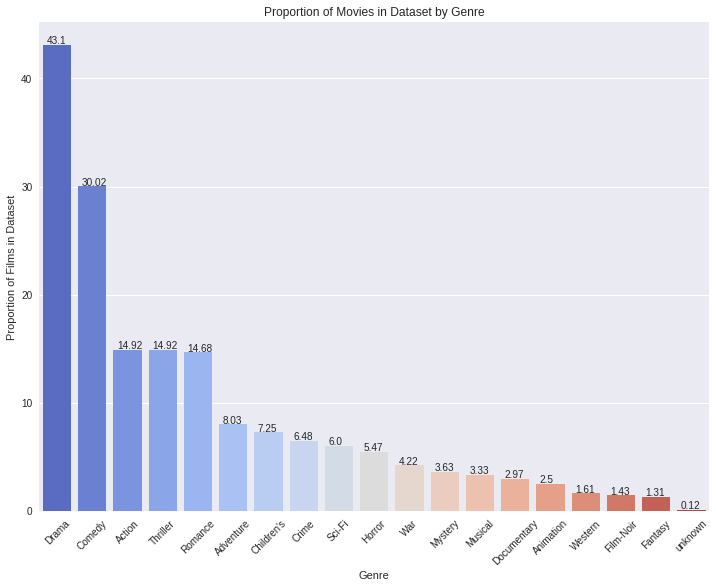

In [42]:
plt.title('Proportion of Movies in Dataset by Genre')
ax = sns.barplot(x='genre', y='proportions', data=g_proport, palette='coolwarm')
plt.ylabel('Proportion of Films in Dataset')
plt.xlabel('Genre')
plt.xticks(rotation=45)

yposlist = list(g_proport['proportions'])
yposlist = [pos + 0.1 for pos in yposlist]
xposlist = range(len(yposlist))
xposlist = [pos-0.3 for pos in xposlist]
stringlist = g_proport['prop_string']

for i in range(len(stringlist)):
    ax.text(xposlist[i], yposlist[i],
          g_proport[g_proport['proportions'] == yposlist[i]-0.1]['prop_string'].values[0],
            fontsize=10)
    
plt.show()

In [43]:
df_genre = pd.merge(items, movie_rating_stats, on='movieId')

df_genre.head()

,movieId,title,release,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_count,movie_mean
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,452,3.878319
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,131,3.206107
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,90,3.033333
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,209,3.550239
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,86,3.302326


In [0]:
# Sort genres by highest mean rating.

g_ratings = pd.DataFrame()
genre_ratings = []

for genre in genrelist:
  genre_rating = df_genre[df_genre[genre] == 1]['movie_mean'].mean()
  genre_ratings.append(genre_rating)

g_ratings['genre'] = genrelist
g_ratings['mean_rating'] = genre_ratings
g_ratings['mean_string'] = g_ratings['mean_rating'].apply(lambda x: str(np.round(x, 2)))

g_ratings = g_ratings.sort_values(by='mean_rating', ascending=False)

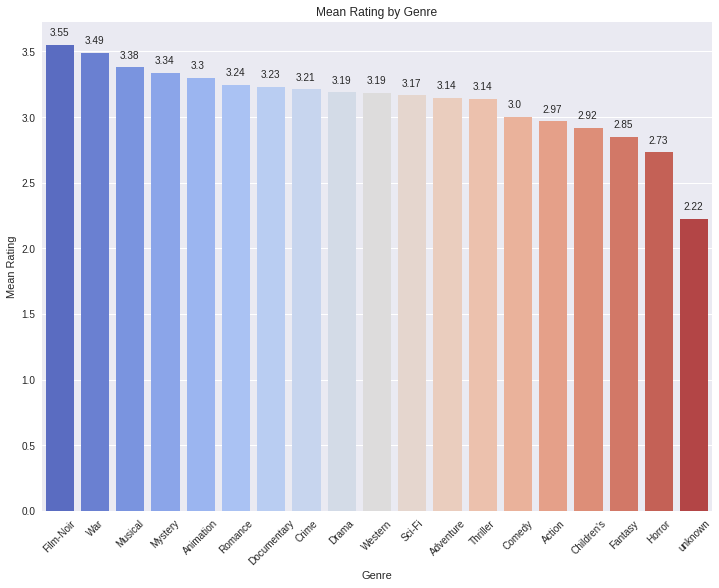

In [45]:
plt.title('Mean Rating by Genre')
ax = sns.barplot(x='genre', y='mean_rating', data=g_ratings, palette='coolwarm')
plt.ylabel('Mean Rating')
plt.xlabel('Genre')
plt.xticks(rotation=45)

yposlist = list(g_ratings['mean_rating'])
yposlist = [pos + 0.07 for pos in yposlist]
xposlist = range(len(yposlist))
xposlist = [pos-0.3 for pos in xposlist]
stringlist = g_ratings['mean_string']

for i in range(len(stringlist)):
    ax.text(xposlist[i], yposlist[i],
          g_ratings[g_ratings['mean_rating'] == yposlist[i]-0.07]['mean_string'].values[0],
            fontsize=10)
    
plt.show()

In [0]:
df_genre['n_genres'] = df_genre[genrelist].sum(axis=1)

In [47]:
df_genre['n_genres'].value_counts()

1    833
2    569
3    215
4     51
5     11
6      3
Name: n_genres, dtype: int64

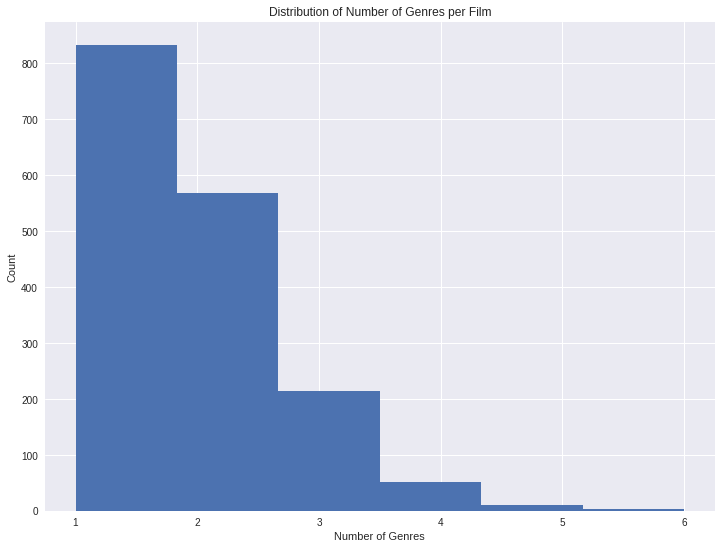

In [48]:
plt.title('Distribution of Number of Genres per Film')
plt.hist(df_genre['n_genres'], bins=6)
plt.xlabel('Number of Genres')
plt.ylabel('Count')
plt.show()

In [49]:
# Movies in the most genre categories:

df_genre[df_genre['n_genres'] == df_genre['n_genres'].max()]

,movieId,title,release,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_count,movie_mean,n_genres
171,172,"Empire Strikes Back, The (1980)",01-Jan-1980,0,1,1,0,0,0,0,...,0,0,1,1,0,1,0,367,4.204360,6
425,426,"Transformers: The Movie, The (1986)",01-Jan-1986,0,1,0,1,1,0,0,...,0,0,0,1,1,1,0,32,2.843750,6
559,560,"Kid in King Arthur's Court, A (1995)",01-Jan-1995,0,0,1,0,1,1,0,...,0,0,1,1,0,0,0,22,2.727273,6


Genre is n-hot-encoded to represent movies that fit multiple categories. This may seem like it makes things more complicated, but it actually means we have a richer dataset than we would if genre were one-hot-encoded.

As it is 20 years old, the list of genres doesn't necessarily account for how these movies would be categorized today (e.g.: the Star Wars films would likely fall under a "space opera" subcategory of science fiction.) Nevertheless, it appears to be a good starting point for understanding user preferences from a top-down perspective.

# Supervised Model

## Feature Engineering

Without using matrix factorization (or neural networks), we can still approximate the effect of vector embeddings by creating new features based on users' genre preferences. Indicators of those preferences may include the proportion of movies of each genre the user has watched, the mean rating each user assigns movies of a particular genre.

We can combine these with the movies' n-hot-encoded genres and their average ratings to achieve an effect similar to matrix factorization-driven collaborative filtering. Here, though, we are explicitly assigning importance based on the supplied categories, rather than relying on latent factors.

This carries with it the advantage of interpretability, but also the disadvantage of biases present in the genre labeling system. Matrix factorization can help account for patterns that are not explicitly stated, and would therefore be excluded from the supervised model.

**We cannot simply take the mean rating given by each user, and the mean rating given to each movie.**

In order to prevent ground-truth data from leaking into our independent variables, we must exclude any information pertaining to a given user-movie pair from the prediction of the rating for that user-movie pair. The mean rating of a user in this dataset takes into account all movies that user has rated, *including* the one we're trying to predict as part of the training set. We don't want it to include that movie, so we'll have to compute the mean rating for *other* movies that user has rated. The same goes for movies.

In [51]:
# This takes a while. A try-except block lets us avoid having to run this more than once.

try:
  df_supervised = pd.read_csv('/content/drive/Colab Notebooks/ml-100k/df_super.csv',
                        index_col=0)
except FileNotFoundError:
  # Create DataFrame as a space to create supervised learning features:
  
  df_supervised = pd.merge(df_merged, items[['movieId'] + genrelist],
                           on='movieId')

  # User count in this context will mean "other movies reviewed" instead of
  # "total movies reviewed." Therefore, we decrease the total count by 1.
  df_supervised['user_count'] = df_supervised['user_count'] - 1
  
  
  # Create features representing average ratings user has given movies of
  # specific genres, excluding ratings given to the film in question.
  
  # Because of the conditional complexity of this operation, we're going to use
  # for loops instead of list comprehensions.
  
  for genre in genrelist:

    columnname1 = genre + '_mean'
    columnname2 = genre + '_count'
    print(genre)

    other_means = []
    other_counts = []

    for userid, movieid in zip(df_supervised['userId'], df_supervised['movieId']):
      
      # Only average user's ratings of other films:
      conditions = (df_supervised[genre] == 1) & (df_supervised['userId'] == userid) & (df_supervised['movieId'] != movieid)

      if len(df_supervised[conditions]) == 0:

        other_means.append(0)
        other_counts.append(0)

      else:

        other_means.append(df_supervised[conditions]['rating'].mean())
        other_counts.append(df_supervised[conditions]['rating'].count())

    df_supervised[columnname1] = other_means
    df_supervised[columnname2] = other_counts
  
  
  # Create mean score for each user/movie pair that excludes current movie/user
  movie_other_means = []
  user_other_means = []

  for userid, movieid in zip(df_supervised['userId'], df_supervised['movieId']):
    
    # Only average movie's ratings by other users:
    movie_other_means.append(df_supervised[(df_supervised['userId'] != userid) & (df_supervised['movieId'] == movieid)]['rating'].mean())
    
    # Only average user's ratings of other films:
    user_other_means.append(df_supervised[(df_supervised['movieId'] != movieid) & (df_supervised['userId'] == userid)]['rating'].mean())

  df_supervised['movie_other_means'] = movie_other_means
  df_supervised['user_other_means'] = user_other_means
  
  # We will impute the mean for movies with only one rating:
  df_supervised['movie_other_means'] = df_supervised['movie_other_means'].fillna(3.529860)
  
  
  for genre in genrelist:
    
    # Get proportion of films of a given genre that a user has rated:
    columnname3 = genre + '_proportion'

    df_supervised[columnname3] = df_supervised[genre+'_count'] / df_supervised['user_count']

unknown
Action
Adventure
Animation
Children's
Comedy
Crime
Documentary
Drama
Fantasy
Film-Noir
Horror
Musical
Mystery
Romance
Sci-Fi
Thriller
War
Western


This takes a while to run (almost two hours on a Google Compute GPU), so we've saved it as a .csv file.

In [0]:
# The first time this block is run, the csv will not yet exist.
# Thereafter, pandas will read in the csv.

try:
  df_supervised = pd.read_csv('/content/drive/Colab Notebooks/ml-100k/df_super.csv',
                        index_col=0)
except FileNotFoundError:
  df_supervised.to_csv('/content/drive/Colab Notebooks/ml-100k/df_super.csv')
  df_supervised = pd.read_csv('/content/drive/Colab Notebooks/ml-100k/df_super.csv',
                      index_col=0)

In [53]:
df_supervised.head()

,userId,movieId,rating,title,user_count,user_mean,movie_count,movie_mean,unknown,Action,...,Fantasy_proportion,Film-Noir_proportion,Horror_proportion,Musical_proportion,Mystery_proportion,Romance_proportion,Sci-Fi_proportion,Thriller_proportion,War_proportion,Western_proportion
0,196,242,3.0,Kolya (1996),38,3.615385,117,3.991453,0,0,...,0.026316,0.000000,0.00000,0.000000,0.000000,0.289474,0.052632,0.000000,0.052632,0.000000
1,63,242,3.0,Kolya (1996),92,3.118280,117,3.991453,0,0,...,0.000000,0.010870,0.01087,0.043478,0.054348,0.206522,0.086957,0.228261,0.054348,0.000000
2,226,242,5.0,Kolya (1996),49,3.800000,117,3.991453,0,0,...,0.000000,0.020408,0.00000,0.040816,0.061224,0.122449,0.183673,0.224490,0.102041,0.040816
3,154,242,3.0,Kolya (1996),50,3.960784,117,3.991453,0,0,...,0.000000,0.100000,0.06000,0.040000,0.160000,0.160000,0.200000,0.160000,0.160000,0.000000
4,306,242,5.0,Kolya (1996),31,3.781250,117,3.991453,0,0,...,0.000000,0.000000,0.00000,0.064516,0.000000,0.258065,0.096774,0.064516,0.096774,0.000000


In [0]:
# Organize features by genre:

meanlist = [genre+'_mean' for genre in genrelist]
proportionlist = [genre+'_proportion' for genre in genrelist]

In [0]:
try:
  features_super = pd.read_csv('/content/drive/Colab Notebooks/ml-100k/features_super.csv',
                        index_col=0)
except:

  features_super = pd.DataFrame(df_supervised[['userId', 'movieId', 'rating', 'user_other_means',
                           'movie_other_means'] + meanlist + genrelist + proportionlist])
  features_super.to_csv('/content/drive/Colab Notebooks/ml-100k/features_super.csv')
  features_super = pd.read_csv('/content/drive/Colab Notebooks/ml-100k/features_super.csv',
                        index_col=0)

In [56]:
features_super.head()

,userId,movieId,rating,user_other_means,movie_other_means,unknown_mean,Action_mean,Adventure_mean,Animation_mean,Children's_mean,...,Fantasy_proportion,Film-Noir_proportion,Horror_proportion,Musical_proportion,Mystery_proportion,Romance_proportion,Sci-Fi_proportion,Thriller_proportion,War_proportion,Western_proportion
0,196,242,3,3.631579,4.000000,0.0,1.666667,2.500,0.000000,4.00,...,0.025641,0.000000,0.000000,0.000000,0.000000,0.282051,0.051282,0.000000,0.051282,0.00
1,63,242,3,3.119565,4.000000,0.0,2.800000,2.875,2.600000,2.25,...,0.000000,0.010753,0.010753,0.043011,0.053763,0.204301,0.086022,0.225806,0.053763,0.00
2,226,242,5,3.775510,3.982759,0.0,3.625000,3.750,4.333333,3.00,...,0.000000,0.020000,0.000000,0.040000,0.060000,0.120000,0.180000,0.220000,0.100000,0.04
3,154,242,3,3.980000,4.000000,0.0,4.125000,4.000,0.000000,0.00,...,0.000000,0.098039,0.058824,0.039216,0.156863,0.156863,0.196078,0.156863,0.156863,0.00
4,306,242,5,3.741935,3.982759,0.0,4.000000,4.000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.062500,0.000000,0.250000,0.093750,0.062500,0.093750,0.00


#### Correlation Matrix Heatmap

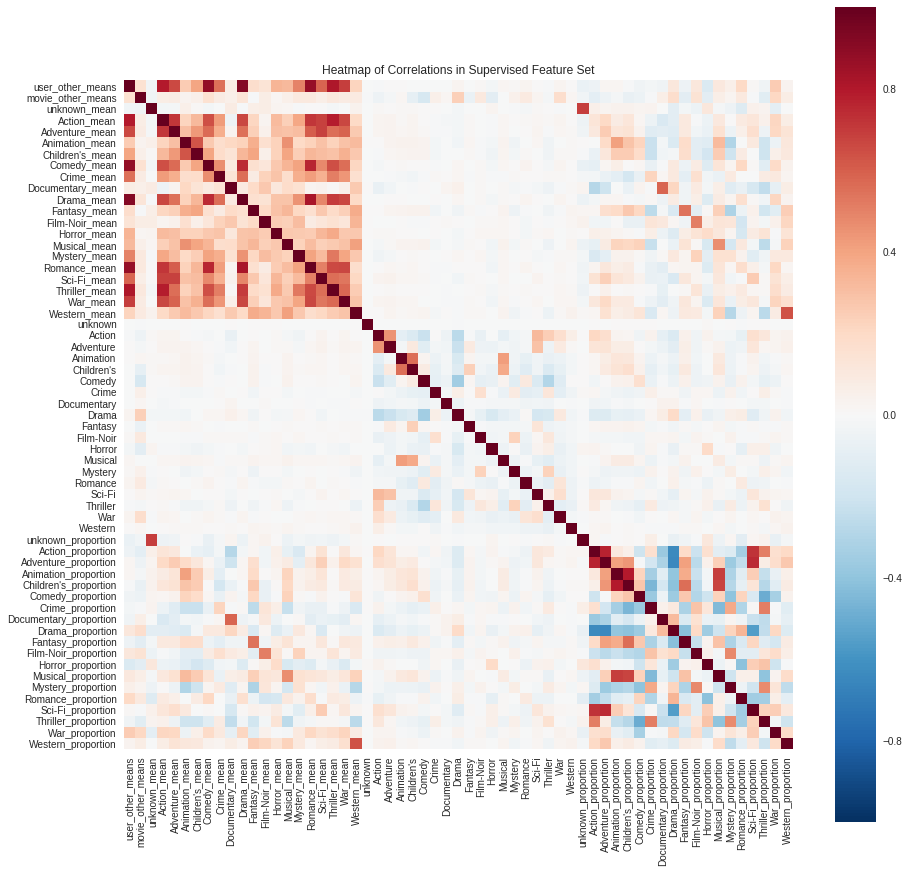

In [57]:
# Visualization of correlations between features in supervised feature set.

plt.rcParams['figure.figsize'] = 15, 15

plt.title('Heatmap of Correlations in Supervised Feature Set')
sns.heatmap(features_super.drop(['rating', 'userId', 'movieId'], 1).corr(),
            square=True)
plt.show()

plt.rcParams['figure.figsize'] = 12, 9

Features for the supervised models include the mean rating the user has given other movies, the mean rating other users have given the movie, the mean rating the user has given movies of each provided genre (excluding the movie in question), and the proportion of movies of each genre the user has watched (also excluding the movie in question).

Because the mean scores and proportions are calculated per pair of user and movie, feature creation was quite computationally complex, requiring a new mean to be calculated for each movie that excludes information based on the rating relationship between specific movie and specific user.

We see some collinearity here between features connected with some genres, such as "Action-Adventure" and "Children's-Animation." This is somewhat unavoidable because of the overlapping nature of genre features, so we won't worry too much about it for now.

##SKLearn Models:

In [0]:
# We will use RMSE as our loss measurement because it is sensitive to large
# deviations from ground truth. "rmse" is already occupied by a fast.ai function.

def sk_rmse(y_true, y_pred):
  """Root Mean-Squared Error. Follows same input
     structure as mean_squared_error in SKLearn"""
  return np.sqrt(mse(y_true, y_pred))

Ordinarily, we'd use something closer to 67-33 or 70-30 for SKLearn models, and 90-10 for neural net models, so we're compromising with an 80-20 split.


In [0]:
X = features_super.drop(['rating'], 1)
y = features_super['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                      test_size=0.2, random_state=0)

### Multinomial Logistic Regression

Logistic regression isn't really built for this task, but given the discrete nature of the target variable, we could attempt to predict the rating with a classifier instead of with regression.

In [60]:
# Discrete value output may not be as effective as continuous regression output.

logit = LogisticRegression(solver='saga', multi_class='multinomial')

logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [61]:
# R-squared coefficient:

logit.score(X_train, y_train)

0.3592

In [62]:
# R-squared coefficient:

logit.score(X_test, y_test)

0.3663

In [63]:
# Calculate root mean-squared error for train set:

sk_rmse(y_train, logit.predict(X_train))

1.1372224936220705

In [64]:
# Calculate root mean-squared error for test set:

sk_rmse(y_test, logit.predict(X_test))

1.127186763584456

The loss here is very high... in fact, it's as high as the root mean-squared error if we just predicted the mean for every single user-movie pair.

In [65]:
sk_rmse(y_test, [3.530 for n in range(len(y_test))])

1.1213795075709205

We'd like to reduce it to below the lowest listed benchmark for this datset from [librec.net](https://www.librec.net/release/v1.3/example.html), 0.911 RMSE.

### Linear Regression

Linear regression is more along the lines of what we're really trying to do here, because it can be used to predict exact ratings (by using the rounded result), as well as to rank those predictions. We'll be computing error based on rounded scores, but in production, the more granular values given by linear regression (or other forms of regression) could be used to create a "top 15" list of movie recommendations.

In [66]:
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [67]:
# R-squared coefficient:

lr.score(X_train, y_train)

0.2887381088226395

In [68]:
# R-squared coefficient:

lr.score(X_test, y_test)

0.29162775225060533

In [69]:
# Calculate root mean-squared error for train set:

sk_rmse(y_train, lr.predict(X_train))

0.9502455983868972

In [70]:
# Calculate root mean-squared error for test set:

sk_rmse(y_test, lr.predict(X_test))

0.9437551593581385

In [71]:
# RMSE for rounded prediction:

sk_rmse(y_test, np.round(lr.predict(X_test), 0))

0.9848857801796105

Linear regression doesn't seem to be getting us anywhere, either, as the error is only slightly better than multinomial logistic regression. Let's try a random forest regressor model... this should help deal with the inherent collinearity of our features:

### Random Forest Regression

Random forest is less transparent than linear regression, but it has the advantage of giving more weight to more signficant features of the data set. Feature redundancies tend to work themselves out more easily in ensemble models.

#### n_estimators = 10 (current SKLearn default)

In [72]:
rfr = RandomForestRegressor(n_jobs=-1)

rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [73]:
# R-squared coefficient:

rfr.score(X_train, y_train)

0.9425131700364708

In [74]:
# R-squared coefficient:

rfr.score(X_test, y_test)

0.6997572900702902

In [75]:
# Calculate root mean-squared error for test set:

sk_rmse(y_train, rfr.predict(X_train))

0.27015018970935406

In [76]:
# Calculate root mean-squared error for test set:

sk_rmse(y_test, rfr.predict(X_test))

0.6144192379800619

In [77]:
# RMSE for rounded prediction:

sk_rmse(y_test, np.round(rfr.predict(X_test), 0))

0.6542553018508906

 There appears to be quite a bit of overfitting, but that root mean-squared error is much better. We've surpassed the benchmark already! Let's see if that can be improved by adding more trees to the forest.

#### n_estimators = 100 (future SKLearn default)

In [78]:
rfr2 = RandomForestRegressor(n_estimators=100, n_jobs=-1)

rfr2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [79]:
# R-squared coefficient:

rfr2.score(X_train, y_train)

0.9629935821976122

In [80]:
# R-squared coefficient:

rfr2.score(X_test, y_test)

0.739013707656712

In [81]:
# Calculate root mean-squared error for train set:

sk_rmse(y_train, rfr2.predict(X_train))

0.21675025663191266

In [82]:
# Calculate root mean-squared error for test set:

sk_rmse(y_test, rfr2.predict(X_test))

0.5728453848989271

In [83]:
# RMSE for rounded prediction:

sk_rmse(y_test, np.round(rfr2.predict(X_test), 0))

0.6063002556489647

Even better! Let's try a grid search with cross validation and see how low and how consistent we can make that error score.

### Cross-Validation Sets

Ordinarily, we'd use GridSearchCV and cross_val_score for k-folds validation, but we'd like to compare the results of this grid search as precisely as we can to the neural network models. Since SKLearn's cross_val_score splits the data into k folds internally, and we want to be able to access those folds outside of SKLearn models, we'll have to do this part manually using pandas' .sample().

In [0]:
# Create test set indices for cross-validation:
test_index_a = list(df_merged.sample(20000, random_state=0).index.sort_values())
test_index_b = list(df_merged[~df_merged.index.isin(test_index_a)].sample(20000,
                              random_state=0).index.sort_values())
sampled = test_index_a + test_index_b
test_index_c = list(df_merged[~df_merged.index.isin(sampled)].sample(20000,
                              random_state=0).index.sort_values())
sampled += test_index_c
test_index_d = list(df_merged[~df_merged.index.isin(sampled)].sample(20000,
                              random_state=0).index.sort_values())
sampled += test_index_d
test_index_e = list(df_merged[~df_merged.index.isin(sampled)].index.sort_values())

# List of indices for test sets:
test_indices = [test_index_a, test_index_b, test_index_c,
                test_index_d, test_index_e]

# Create training set indices for cross-validation:
train_index_a = df_merged[~df_merged.index.isin(test_index_a)].index.sort_values().tolist()
train_index_b = df_merged[~df_merged.index.isin(test_index_b)].index.sort_values().tolist()
train_index_c = df_merged[~df_merged.index.isin(test_index_c)].index.sort_values().tolist()
train_index_d = df_merged[~df_merged.index.isin(test_index_d)].index.sort_values().tolist()
train_index_e = df_merged[~df_merged.index.isin(test_index_e)].index.sort_values().tolist()

# List of indices for train sets:
train_indices = [train_index_a, train_index_b, train_index_c,
                 train_index_d, train_index_e]

In [0]:
# Train-test split will use the same index values as the other models:

X_train_a = features_super.iloc[train_index_a].drop(['rating'], 1)
X_test_a = features_super.iloc[test_index_a].drop(['rating'], 1)
X_train_b = features_super.iloc[train_index_b].drop(['rating'], 1)
X_test_b = features_super.iloc[test_index_b].drop(['rating'], 1)
X_train_c = features_super.iloc[train_index_c].drop(['rating'], 1)
X_test_c = features_super.iloc[test_index_c].drop(['rating'], 1)
X_train_d = features_super.iloc[train_index_d].drop(['rating'], 1)
X_test_d = features_super.iloc[test_index_d].drop(['rating'], 1)
X_train_e = features_super.iloc[train_index_e].drop(['rating'], 1)
X_test_e = features_super.iloc[test_index_e].drop(['rating'], 1)

y_train_a = features_super.iloc[train_index_a]['rating'].values
y_test_a = features_super.iloc[test_index_a]['rating'].values
y_train_b = features_super.iloc[train_index_b]['rating'].values
y_test_b = features_super.iloc[test_index_b]['rating'].values
y_train_c = features_super.iloc[train_index_c]['rating'].values
y_test_c = features_super.iloc[test_index_c]['rating'].values
y_train_d = features_super.iloc[train_index_d]['rating'].values
y_test_d = features_super.iloc[test_index_d]['rating'].values
y_train_e = features_super.iloc[train_index_e]['rating'].values
y_test_e = features_super.iloc[test_index_e]['rating'].values

folds = ['a', 'b', 'c', 'd', 'e']

X_trains = [X_train_a, X_train_b, X_train_c, X_train_d, X_train_e]
X_tests = [X_test_a, X_test_b, X_test_c, X_test_d, X_test_e]
y_trains = [y_train_a, y_train_b, y_train_c, y_train_d, y_train_e]
y_tests = [y_test_a, y_test_b, y_test_c, y_test_d, y_test_e]

### Grid Search

A higher min_samples_split can sometimes reduce noise in decision trees. We'll iterate over 2, 4, and 8 for a start. The number of trees in the forest can also have an effect on accuracy and consistency, so we'll test out 50-tree, 100-tree, and 150-tree models.


In [0]:
parameter_space_rfr = {'min_samples_split':[2, 4, 8], 'n_estimators':[50, 100, 150]}

In [0]:
try:
  rfr_gridsearch = pd.read_csv('/content/drive/Colab Notebooks/ml-100k/rfr_grid.csv',
                        index_col=0)
except FileNotFoundError:
  #Create empty DataFrame to hold grid search data:
  rfr_gridsearch = pd.DataFrame()
  
  #Create empty lists to be turned into DataFrame

  namelist_rfr = []

  trainloss_a = []
  trainloss_b = []
  trainloss_c = []
  trainloss_d = []
  trainloss_e = []

  testloss_a = []
  testloss_b = []
  testloss_c = []
  testloss_d = []
  testloss_e = []


  for min_samples_split in parameter_space_rfr['min_samples_split']:
    for n_estimators in parameter_space_rfr['n_estimators']:

      algoname = 'RFR_min_samples:{}_n_estimators:{}'.format(min_samples_split,
                                                          n_estimators)
      namelist_rfr.append(algoname)
      print(algoname)

      trainlosses = []
      testlosses = []
      
      kfoldsset = zip(folds, X_trains, X_tests, y_trains, y_tests)
      
      for fold, X_train, X_test, y_train, y_test in kfoldsset:
        print(fold)
        rfr = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1,
                       min_samples_split=min_samples_split)
        rfr.fit(X_train, y_train)
        trainlosses.append(sk_rmse(y_train, np.round(rfr.predict(X_train), 0)))
        print(trainlosses[-1])
        testlosses.append(sk_rmse(y_test, np.round(rfr.predict(X_test), 0)))
        print(testlosses[-1])

      trainloss_a.append(trainlosses[0])
      trainloss_b.append(trainlosses[1])
      trainloss_c.append(trainlosses[2])
      trainloss_d.append(trainlosses[3])
      trainloss_e.append(trainlosses[4])

      testloss_a.append(testlosses[0])
      testloss_b.append(testlosses[1])
      testloss_c.append(testlosses[2])
      testloss_d.append(testlosses[3])
      testloss_e.append(testlosses[4])

  rfr_gridsearch['parameter_list'] = namelist_rfr

  rfr_gridsearch['trainloss_a'] = trainloss_a
  rfr_gridsearch['trainloss_b'] = trainloss_b
  rfr_gridsearch['trainloss_c'] = trainloss_c
  rfr_gridsearch['trainloss_d'] = trainloss_d
  rfr_gridsearch['trainloss_e'] = trainloss_e

  rfr_gridsearch['testloss_a'] = testloss_a
  rfr_gridsearch['testloss_b'] = testloss_b
  rfr_gridsearch['testloss_c'] = testloss_c
  rfr_gridsearch['testloss_d'] = testloss_d
  rfr_gridsearch['testloss_e'] = testloss_e

  rfr_gridsearch['mean_train_loss'] = rfr_gridsearch[['trainloss_a',
                                                      'trainloss_b',
                                                      'trainloss_c',
                                                      'trainloss_d',
                                                      'trainloss_e']].mean(axis=1)

  rfr_gridsearch['mean_test_loss'] = rfr_gridsearch[['testloss_a',
                                                   'testloss_b',
                                                   'testloss_c',
                                                   'testloss_d',
                                                   'testloss_e']].mean(axis=1)
  
  rfr_gridsearch['train_loss_std'] = rfr_gridsearch[['trainloss_a',
                                                      'trainloss_b',
                                                      'trainloss_c',
                                                      'trainloss_d',
                                                      'trainloss_e']].std(axis=1)
  
  rfr_gridsearch['test_loss_std'] = rfr_gridsearch[['testloss_a',
                                                   'testloss_b',
                                                   'testloss_c',
                                                   'testloss_d',
                                                   'testloss_e']].std(axis=1)

  rfr_gridsearch.to_csv('/content/drive/Colab Notebooks/ml-100k/rfr_grid.csv')

In [0]:
# Results of Random Forest Regression grid search:

rfr_gridsearch = pd.read_csv('/content/drive/Colab Notebooks/ml-100k/rfr_grid.csv',
                        index_col=0)

In [89]:
rfr_gridsearch[rfr_gridsearch['mean_test_loss'] == rfr_gridsearch['mean_test_loss'].min()]

,parameter_list,trainloss_a,trainloss_b,trainloss_c,trainloss_d,trainloss_e,testloss_a,testloss_b,testloss_c,testloss_d,testloss_e,mean_train_loss,mean_test_loss,train_loss_std,test_loss_std
2,RFR_min_samples:2_n_estimators:150,0.211572,0.213307,0.211128,0.209045,0.211512,0.603945,0.621168,0.601166,0.610451,0.605599,0.211313,0.608466,0.001521,0.007862


Unsurprisingly, the 150-tree model peformed the best. Increasing the minimum number of samples required for a node to split did not appear to increase performance. 

0.608 RMSE is the new error number to beat! (This number is higher than what we got from the original test, but that wasn't cross-validated so it may have been a fluke.) Next, we will try some  neural net models for matrix factorization.

# Neural Net Modeling

## fast.ai Model (Collab)

fast.ai, a research foundation and Massive Online Open Classroom, has its own machine learning modules built on top of PyTorch. The models contained therein are usable out-of-the-box with very little setup, and therefore provide a good starting point both for beginning ML practitioners, and as a sort of benchmark for other machine learning models.

Some of the objects in their module are very similar to pandas objects (such as "DataBunch" instead of "DataFrame"), but contain other information.

The ease of use provided by the fast.ai library does come with the drawback of less flexibility in terms of parameter adjustment, and insight into what the models are actually *doing*.

In [0]:
data = CollabDataBunch.from_df(df_merged[['userId', 'movieId', 'rating', 'title']],
                               seed=0, valid_pct=0.2, item_name='title')

In [91]:
# Default batch size for training the neural net:

data.batch_size

64

In [92]:
data.show_batch()

userId,title,target
334,G.I. Jane (1997),1.0
543,Jaws (1975),4.0
314,"Little Princess, The (1939)",4.0
81,"Nutty Professor, The (1996)",2.0
385,Raising Arizona (1987),5.0


In [0]:
y_range = [0, 5.5]

We'll first try a few different numbers of latent factors, and see roughly what we should aim for.

### 15 Factors

In [0]:
learn0 = collab_learner(data, n_factors=15, y_range=y_range, wd=5e-2, callback_fns=[CSVLogger])

In [95]:
learn0.loss_func

FlattenedLoss of MSELoss()

epoch,train_loss,valid_loss,time
1,0.954354,0.940400,00:12
2,0.898007,0.858900,00:12
3,0.794903,0.825336,00:12
4,0.751781,0.808891,00:12
5,0.670111,0.808476,00:12


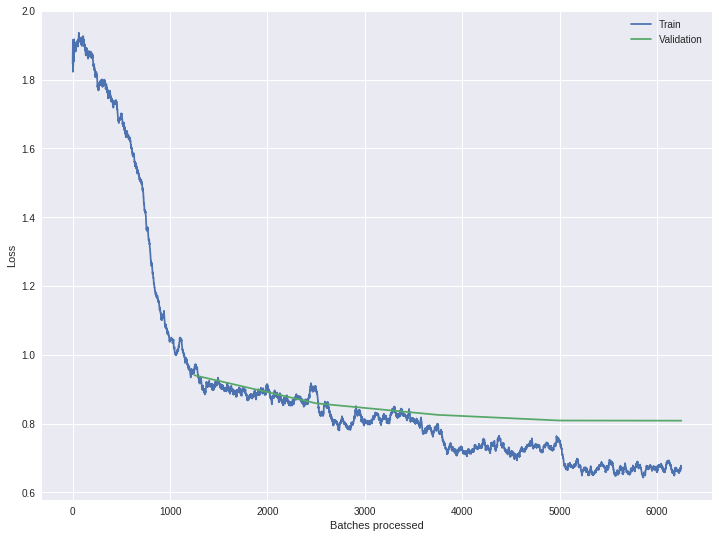

In [96]:
learn0.fit_one_cycle(5, 5e-3, moms=(0.95, 0.85))
learn0.recorder.plot_losses()

In [0]:
learn0_table = learn0.csv_logger.read_logged_file()

In [98]:
learn0_table

,epoch,train_loss,valid_loss,time
0,1,0.954354,0.940400,NaN
1,2,0.898007,0.858900,NaN
2,3,0.794903,0.825336,NaN
3,4,0.751781,0.808891,NaN
4,5,0.670111,0.808476,NaN


In [99]:
# Calculate RMSE from Mean-Squared Error

fai_train_rmse = np.sqrt(learn0_table.train_loss.values[-1])
fai_valid_rmse = np.sqrt(learn0_table.valid_loss.values[-1])

print("Training loss:", fai_train_rmse)
print("Validation loss", fai_valid_rmse)

Training loss: 0.8186030784207936
Validation loss 0.8991529347113315


### 30 Factors

In [0]:
learn1 = collab_learner(data, n_factors=30, y_range=y_range, wd=5e-2, callback_fns=[CSVLogger])

In [101]:
learn1.loss_func

FlattenedLoss of MSELoss()

epoch,train_loss,valid_loss,time
1,0.957000,0.939039,00:12
2,0.877911,0.862359,00:12
3,0.782193,0.824408,00:12
4,0.618208,0.816737,00:12
5,0.533712,0.818084,00:12


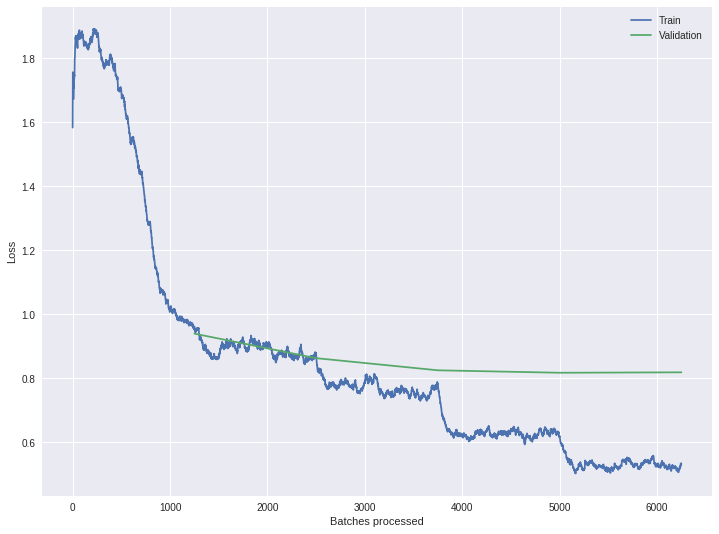

In [102]:
learn1.fit_one_cycle(5, 5e-3, moms=(0.95, 0.85))
learn1.recorder.plot_losses()

In [0]:
learn1_table = learn1.csv_logger.read_logged_file()

In [104]:
learn1_table

,epoch,train_loss,valid_loss,time
0,1,0.957000,0.939039,NaN
1,2,0.877911,0.862359,NaN
2,3,0.782193,0.824408,NaN
3,4,0.618208,0.816737,NaN
4,5,0.533712,0.818084,NaN


In [105]:
# Calculate RMSE from Mean-Squared Error

fai_train_rmse = np.sqrt(learn1_table.train_loss.values[-1])
fai_valid_rmse = np.sqrt(learn1_table.valid_loss.values[-1])

print("Training loss:", fai_train_rmse)
print("Validation loss", fai_valid_rmse)

Training loss: 0.7305559526826128
Validation loss 0.9044799610826102


### 45 Factors

In [0]:
learn2 = collab_learner(data, n_factors=45, y_range=y_range, wd=5e-2, callback_fns=[CSVLogger])

In [107]:
learn2.loss_func

FlattenedLoss of MSELoss()

epoch,train_loss,valid_loss,time
1,0.979437,0.941223,00:12
2,0.846601,0.862074,00:12
3,0.731772,0.819284,00:12
4,0.526435,0.822216,00:12
5,0.417265,0.825810,00:12


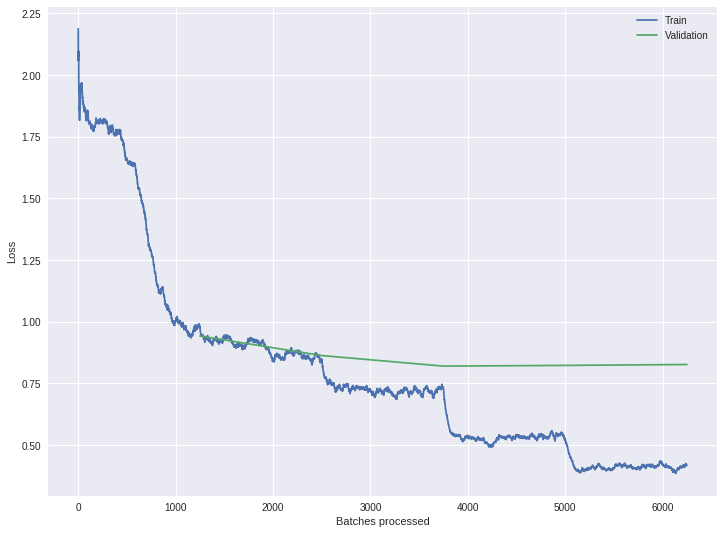

In [108]:
learn2.fit_one_cycle(5, 5e-3, moms=(0.95, 0.85))
learn2.recorder.plot_losses()

In [0]:
learn2_table = learn2.csv_logger.read_logged_file()

In [110]:
learn2_table

,epoch,train_loss,valid_loss,time
0,1,0.979437,0.941223,NaN
1,2,0.846601,0.862074,NaN
2,3,0.731772,0.819284,NaN
3,4,0.526435,0.822216,NaN
4,5,0.417265,0.825810,NaN


In [111]:
# Calculate RMSE from Mean-Squared Error

fai_train_rmse = np.sqrt(learn2_table.train_loss.values[-1])
fai_valid_rmse = np.sqrt(learn2_table.valid_loss.values[-1])

print("Training loss:", fai_train_rmse)
print("Validation loss", fai_valid_rmse)

Training loss: 0.6459605251097005
Validation loss 0.9087408871620117


These scores are all pretty good! They just barely beat the benchmarks from librec.net, but that's a good start. Let's try a grid search to see if we can improve them.

### Cross-Validation Sets

The fast.ai library lacks a dedicated grid search class, and also doesn't have cross-validation built in, so we're going to have to do this manually. 

By default, fastai's CollabDataBunch object does its own random splitting into "train" and "valid" according to the valid_pct parameter. Since we want to load in our own pre-split segments to perform actual cross-validation, we can bypass the fastai train-test split by loading in our train set (one for each fold), setting valid_pct to 0 so none of it is split into a train set, then using the optional "test" parameter to load in the data we want to use for validation.

We can then swap in the test_ds.x (test dataset) attribute for the valid_ds.x attribute, and just use our "rating" ground truth in list form as the valid_ds.y attribute. (N.B.: a list can be loaded in as the target variable, but independent variables yield an error when this is attempted.)

This method is a bit of a kludge, but it lets us evaluate our models using the same movie-user indices in k-fold cross-validation.

In [112]:
# CollabDataBunch A
data_a = CollabDataBunch.from_df(df_merged.iloc[train_index_a][['userId', 'movieId', 'rating']],
                                 test=df_merged.iloc[test_index_a][['userId', 'movieId', 'rating']],
                                 valid_pct=0)

data_a.valid_ds.x = data_a.test_ds.x
data_a.valid_ds.y = list(df_merged.iloc[test_index_a]['rating'])

# CollabDataBunch B
data_b = CollabDataBunch.from_df(df_merged.iloc[train_index_b][['userId', 'movieId', 'rating']],
                                 test=df_merged.iloc[test_index_b][['userId', 'movieId', 'rating']],
                                 valid_pct=0)

data_b.valid_ds.x = data_b.test_ds.x
data_b.valid_ds.y = list(df_merged.iloc[test_index_b]['rating'])

# CollabDataBunch C
data_c = CollabDataBunch.from_df(df_merged.iloc[train_index_c][['userId', 'movieId', 'rating']],
                                 test=df_merged.iloc[test_index_c][['userId', 'movieId', 'rating']],
                                 valid_pct=0)

data_c.valid_ds.x = data_c.test_ds.x
data_c.valid_ds.y = list(df_merged.iloc[test_index_c]['rating'])

# CollabDataBunch D
data_d = CollabDataBunch.from_df(df_merged.iloc[train_index_d][['userId', 'movieId', 'rating']],
                                 test=df_merged.iloc[test_index_d][['userId', 'movieId', 'rating']],
                                 valid_pct=0)

data_d.valid_ds.x = data_d.test_ds.x
data_d.valid_ds.y = list(df_merged.iloc[test_index_d]['rating'])

# CollabDataBunch E
data_e = CollabDataBunch.from_df(df_merged.iloc[train_index_e][['userId', 'movieId', 'rating']],
                                 test=df_merged.iloc[test_index_e][['userId', 'movieId', 'rating']],
                                 valid_pct=0)

data_e.valid_ds.x = data_e.test_ds.x
data_e.valid_ds.y = list(df_merged.iloc[test_index_e]['rating'])

# Sample Batch for data_a:

data_a.show_batch()

y_range = [0, 5.5]

userId,movieId,target
43,479,4.0
601,1063,3.0
276,951,3.0
405,702,1.0
707,603,3.0


### Grid Search

The model with 15 latent factors performed marginally better than the other two, so we'll include 15 and 20 as part of our parameter space for the grid search, along with slightly increased learning rate, and adjusted momentums.

In [0]:
parameter_space_fai = {'lr':[5e-3, 7e-3], 'moms':[(0.95, 0.85), (0.95, 0.7)],
                  'n_factors':[15, 20]}

databunches = [data_a, data_b, data_c, data_d, data_e]

In [0]:
try:
  fai_gridsearch = pd.read_csv('/content/drive/Colab Notebooks/ml-100k/fai_gridsearch.csv',
                        index_col=0)
except FileNotFoundError:
  
  #Create empty DataFrame to hold grid search data:
  fai_gridsearch = pd.DataFrame()
  
  #Create empty lists to be turned into DataFrame
  
  namelist_fai = []

  trainloss_a = []
  trainloss_b = []
  trainloss_c = []
  trainloss_d = []
  trainloss_e = []

  testloss_a = []
  testloss_b = []
  testloss_c = []
  testloss_d = []
  testloss_e = []
  
  for lr in parameter_space_fai['lr']:
    for moms in parameter_space_fai['moms']:
      for n_factors in parameter_space_fai['n_factors']:

        algoname = 'Fast.AI_lr:{}_moms:{}_n_factors:{}'.format(lr, moms, n_factors)
        namelist_fai.append(algoname)
        print(algoname)
        
        trainlosses = []
        testlosses = []

        for fold, data in zip(folds, databunches):
          print(fold)
          learn = collab_learner(data, n_factors=n_factors, y_range=y_range,
                                 wd=0.05, callback_fns=[CSVLogger])
          learn.fit_one_cycle(5, lr, moms=moms)

          learn_table = learn.csv_logger.read_logged_file()
          learn_table
          # Calculate RMSE from Mean-Squared Error

          fai_train_rmse = np.sqrt(learn_table.train_loss.values[-1])
          fai_valid_rmse = np.sqrt(learn_table.valid_loss.values[-1])

          trainlosses.append(fai_train_rmse)
          testlosses.append(fai_valid_rmse)
          
          print("Training loss (RMSE):", fai_train_rmse)
          print("Validation loss (RMSE)", fai_valid_rmse)
          
        trainloss_a.append(trainlosses[0])
        trainloss_b.append(trainlosses[1])
        trainloss_c.append(trainlosses[2])
        trainloss_d.append(trainlosses[3])
        trainloss_e.append(trainlosses[4])

        testloss_a.append(testlosses[0])
        testloss_b.append(testlosses[1])
        testloss_c.append(testlosses[2])
        testloss_d.append(testlosses[3])
        testloss_e.append(testlosses[4])
        
        
  fai_gridsearch['parameter_list'] = namelist_fai

  fai_gridsearch['trainloss_a'] = trainloss_a
  fai_gridsearch['trainloss_b'] = trainloss_b
  fai_gridsearch['trainloss_c'] = trainloss_c
  fai_gridsearch['trainloss_d'] = trainloss_d
  fai_gridsearch['trainloss_e'] = trainloss_e

  fai_gridsearch['testloss_a'] = testloss_a
  fai_gridsearch['testloss_b'] = testloss_b
  fai_gridsearch['testloss_c'] = testloss_c
  fai_gridsearch['testloss_d'] = testloss_d
  fai_gridsearch['testloss_e'] = testloss_e

  fai_gridsearch['mean_train_loss'] = fai_gridsearch[['trainloss_a',
                                                      'trainloss_b',
                                                      'trainloss_c',
                                                      'trainloss_d',
                                                      'trainloss_e']].mean(axis=1)

  fai_gridsearch['mean_test_loss'] = fai_gridsearch[['testloss_a',
                                                   'testloss_b',
                                                   'testloss_c',
                                                   'testloss_d',
                                                   'testloss_e']].mean(axis=1)
  
  fai_gridsearch['train_loss_std'] = fai_gridsearch[['trainloss_a',
                                                      'trainloss_b',
                                                      'trainloss_c',
                                                      'trainloss_d',
                                                      'trainloss_e']].std(axis=1)
  
  fai_gridsearch['test_loss_std'] = fai_gridsearch[['testloss_a',
                                                   'testloss_b',
                                                   'testloss_c',
                                                   'testloss_d',
                                                   'testloss_e']].std(axis=1)

  fai_gridsearch.to_csv('/content/drive/Colab Notebooks/ml-100k/fai_gridsearch.csv')

In [115]:
# Results of fastai grid search:

fai_gridsearch

,parameter_list,trainloss_a,trainloss_b,trainloss_c,trainloss_d,trainloss_e,testloss_a,testloss_b,testloss_c,testloss_d,testloss_e,mean_train_loss,mean_test_loss,train_loss_std,test_loss_std
0,"Fast.AI_lr:0.005_moms:(0.95, 0.85)_n_factors:15",0.839319,0.808257,0.817516,0.827626,0.822956,0.900956,0.907425,0.906337,0.909288,0.903564,0.823135,0.905514,0.011565,0.003284
1,"Fast.AI_lr:0.005_moms:(0.95, 0.85)_n_factors:20",0.801914,0.794729,0.774443,0.783945,0.792636,0.898993,0.902039,0.904698,0.908292,0.904681,0.789533,0.903741,0.010593,0.003462
2,"Fast.AI_lr:0.005_moms:(0.95, 0.7)_n_factors:15",0.824411,0.823310,0.814203,0.833266,0.819411,0.899237,0.904692,0.905703,0.911134,0.905060,0.822920,0.905165,0.007031,0.004222
3,"Fast.AI_lr:0.005_moms:(0.95, 0.7)_n_factors:20",0.789369,0.796965,0.792100,0.790396,0.783063,0.898897,0.902086,0.907167,0.906864,0.901962,0.790379,0.903395,0.005022,0.003545
4,"Fast.AI_lr:0.007_moms:(0.95, 0.85)_n_factors:15",0.781001,0.775238,0.764119,0.770327,0.779424,0.900398,0.905679,0.910453,0.909443,0.908247,0.774022,0.906844,0.006912,0.004021
5,"Fast.AI_lr:0.007_moms:(0.95, 0.85)_n_factors:20",0.728439,0.735436,0.741417,0.718139,0.728982,0.905601,0.909615,0.910416,0.915116,0.913444,0.730483,0.910839,0.008702,0.003681
6,"Fast.AI_lr:0.007_moms:(0.95, 0.7)_n_factors:15",0.771587,0.765125,0.782617,0.783462,0.782960,0.898252,0.904670,0.904754,0.912744,0.904499,0.777150,0.904984,0.008352,0.005146
7,"Fast.AI_lr:0.007_moms:(0.95, 0.7)_n_factors:20",0.748532,0.732019,0.729186,0.728811,0.737268,0.906318,0.909937,0.911075,0.910957,0.909605,0.735163,0.909578,0.008202,0.001930


In [116]:
fai_gridsearch[fai_gridsearch['mean_test_loss'] == fai_gridsearch['mean_test_loss'].min()]

,parameter_list,trainloss_a,trainloss_b,trainloss_c,trainloss_d,trainloss_e,testloss_a,testloss_b,testloss_c,testloss_d,testloss_e,mean_train_loss,mean_test_loss,train_loss_std,test_loss_std
3,"Fast.AI_lr:0.005_moms:(0.95, 0.7)_n_factors:20",0.789369,0.796965,0.7921,0.790396,0.783063,0.898897,0.902086,0.907167,0.906864,0.901962,0.790379,0.903395,0.005022,0.003545


This is only slightly lower than the benchmark, but it *is* better.

## Keras

The Keras library turns TensorFlow, Theano, the Microsoft Cognitive Toolkit, and PlaidML into more accessible, modular machine learning frameworks. Keras requires a bit more planning and attention than fast.ai's library, but it makes the four aforementioned libraries much easier to work with. Here, we'll be using the TensorFlow backend.

### Matrix Factorization

We'll be starting with the same technique used in the fast.ai CollabLearner model, with parameter settings as close as we can get.

In [0]:
train, test = train_test_split(df_merged[['userId', 'movieId', 'rating']],
                               test_size=0.2, random_state=0)

In [118]:
train.head()

,userId,movieId,rating
10382,647,237,3.0
73171,318,326,4.0
30938,903,211,5.0
99310,450,1271,2.0
58959,379,517,4.0


In [119]:
n_users = len(df_merged.userId.unique())
n_movies = len(df_merged.movieId.unique())

print(n_users, n_movies)

943 1682


#### 20 Factors, SGD Optimizer modeled after fast.ai parameters

In an attempt to compare fast.ai's collab_learner to Keras' some-assmebly-required models, we'll start by using the same values as we did for our fast.ai model: a stochastic gradient descent optimizer, 0.005 learning rate, 0.95 momentum (Keras' momentum doesn't take a tuple, but ideally we'd have this dip to 0.7), a weight decay of 0.05, and a batch size of 64 (default for both modules).

In [0]:
n_latent_factors = 20

In [0]:
# Here we take the dot product of the embedding layers with the merge.dot layer:

optimizer = keras.optimizers.SGD(lr=0.005, momentum=0.95,
                                 decay=0.05, nesterov=False)

movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1,
                         n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1,
                         n_latent_factors, name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

prod = keras.layers.merge.dot([movie_vec, user_vec], axes=-1)
collab_filter_model = keras.Model([user_input, movie_input], prod)
collab_filter_model.compile(optimizer=optimizer, loss='mean_squared_error')

In [0]:
SVG(model_to_dot(collab_filter_model,  show_shapes=True,
          show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

keras.utils.plot_model(collab_filter_model,
              to_file='/content/drive/Colab Notebooks/ml-100k/keras_model1.png')

In [123]:
collab_filter_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 20)        33660       Movie[0][0]                      
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 20)        18880       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [124]:
collab_filter_history = collab_filter_model.fit([train.userId, train.movieId],
                          train.rating, epochs=25, verbose=1)

Epoch 1/25
80000/80000 [==============================] - 8s 104us/step - loss: 13.7084
Epoch 2/25
80000/80000 [==============================] - 8s 101us/step - loss: 13.7082
Epoch 3/25
80000/80000 [==============================] - 8s 102us/step - loss: 13.7082
Epoch 4/25
80000/80000 [==============================] - 8s 98us/step - loss: 13.7081
Epoch 5/25
80000/80000 [==============================] - 8s 99us/step - loss: 13.7081
Epoch 6/25
80000/80000 [==============================] - 8s 98us/step - loss: 13.7081
Epoch 7/25
80000/80000 [==============================] - 8s 98us/step - loss: 13.7081
Epoch 8/25
80000/80000 [==============================] - 8s 97us/step - loss: 13.7081
Epoch 9/25
80000/80000 [==============================] - 8s 99us/step - loss: 13.7081
Epoch 10/25
80000/80000 [==============================] - 8s 98us/step - loss: 13.7081
Epoch 11/25
80000/80000 [==============================] - 8s 98us/step - loss: 13.7081
Epoch 12/25
80000/80000 [=============

In [125]:
y_pred = collab_filter_model.predict([test.userId, test.movieId])
y_pred_rounded = np.round(collab_filter_model.predict([test.userId, test.movieId]), 0)
y_true = test.rating

print(np.sqrt(mse(y_true, y_pred)))
print(np.sqrt(mse(y_true, y_pred_rounded)))

3.715059020266211
3.715063929463395


This is remarkably poor. The same parameters that worked well in the fast.ai model barely have any loss reduction during training, even after five times the number of epochs.. There is clearly more at work here than these parameters.

Let's try the default settings for the Adam optimizer instead of SGD with the fast.ai settings.

#### 20 Factors, Adam Optimizer, default parameters

In [0]:
n_latent_factors = 20

In [0]:
# 'adam' has a default learning rate of 0.001 and a default weight decay of 0.0.

movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1,
                         n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1,
                         n_latent_factors, name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

prod = keras.layers.merge.dot([movie_vec, user_vec], axes=-1)
collab_filter_model2 = keras.Model([user_input, movie_input], prod)
collab_filter_model2.compile(optimizer='adam', loss='mean_squared_error')

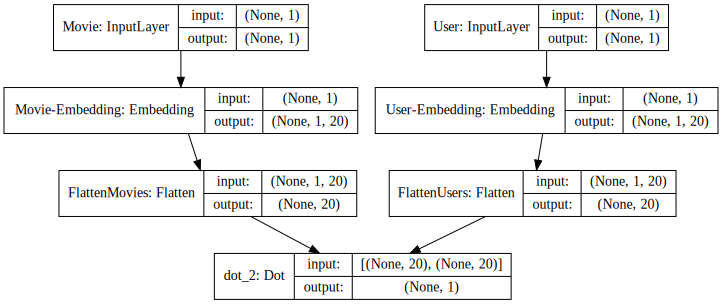

In [128]:
SVG(model_to_dot(collab_filter_model2,  show_shapes=True,
                 show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

In [129]:
collab_filter_model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 20)        33660       Movie[0][0]                      
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 20)        18880       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [130]:
collab_filter_history2 = collab_filter_model2.fit([train.userId, train.movieId],
                          train.rating, epochs=25, verbose=1)

Epoch 1/25
80000/80000 [==============================] - 9s 112us/step - loss: 8.5676
Epoch 2/25
80000/80000 [==============================] - 9s 109us/step - loss: 1.3890
Epoch 3/25
80000/80000 [==============================] - 9s 109us/step - loss: 0.9822
Epoch 4/25
80000/80000 [==============================] - 9s 109us/step - loss: 0.9120
Epoch 5/25
80000/80000 [==============================] - 9s 109us/step - loss: 0.8853
Epoch 6/25
80000/80000 [==============================] - 9s 110us/step - loss: 0.8638
Epoch 7/25
80000/80000 [==============================] - 9s 110us/step - loss: 0.8448
Epoch 8/25
80000/80000 [==============================] - 9s 109us/step - loss: 0.8262
Epoch 9/25
80000/80000 [==============================] - 9s 108us/step - loss: 0.8061
Epoch 10/25
80000/80000 [==============================] - 9s 109us/step - loss: 0.7866
Epoch 11/25
80000/80000 [==============================] - 9s 109us/step - loss: 0.7669
Epoch 12/25
80000/80000 [================

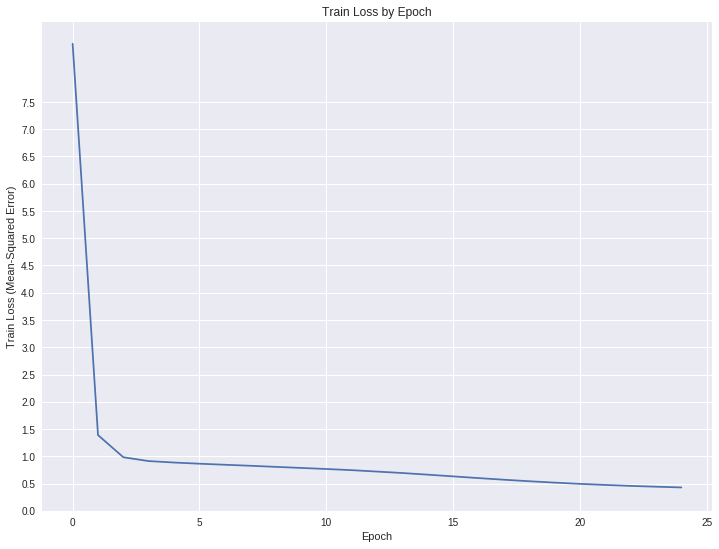

In [131]:
plt.rcParams['figure.figsize'] = 12, 9

plt.title('Train Loss by Epoch')

pd.Series(collab_filter_history2.history['loss']).plot()
plt.yticks(np.arange(0, 8, 0.5))
plt.xlabel('Epoch')
plt.ylabel('Train Loss (Mean-Squared Error)')
plt.show()

In [132]:
y_pred = collab_filter_model2.predict([test.userId, test.movieId])
y_pred_rounded = np.round(collab_filter_model2.predict([test.userId, test.movieId]), 0)
y_true = test.rating

print(np.sqrt(mse(y_true, y_pred)))
print(np.sqrt(mse(y_true, y_pred_rounded)))

0.9981516244739542
1.033706921714274


This is approaching where we should be, but it's still higher than fast.ai and random forest regression.

#### 20 Factors, Added Bias Terms

Bias terms (as described by Jeremy Howard in the fast.ai lecutres on collaborative filtering) are additional weights that accompany the latent factors, but which are not included in the dot product. These can help account for things like a user being stingier with their rating scores than other users, or a movie just being a better movie than others in the dataset.

Each user and each movie gets a bias term (as part of a bias layer). We'll see if this has an impact on our Keras model.

In [0]:
n_latent_factors = 20

In [0]:
movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1,
                         n_latent_factors, name='Movie-Embedding')(movie_input)
movie_bias = keras.layers.Embedding(n_movies+1, output_dim=1, name='Movie-Bias')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1,
                         n_latent_factors, name='User-Embedding')(user_input)
user_bias = keras.layers.Embedding(n_users+1, output_dim=1, name='User-Bias')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

prod = keras.layers.merge.dot([movie_vec, user_vec], axes=-1)
prod = keras.layers.add(inputs=[prod, movie_bias, user_bias])
prod = keras.layers.Flatten()(prod)
collab_bias_model = keras.Model([user_input, movie_input], prod)
collab_bias_model.compile(optimizer='adam', loss='mean_squared_error')

In [0]:
SVG(model_to_dot(collab_bias_model,  show_shapes=True,
                 show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

keras.utils.plot_model(collab_bias_model,
              to_file='/content/drive/Colab Notebooks/ml-100k/keras_model2.png')


In [136]:
collab_bias_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 20)        33660       Movie[0][0]                      
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 20)        18880       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [137]:
collab_bias_history = collab_bias_model.fit([train.userId, train.movieId],
                          train.rating, epochs=25, verbose=1)

Epoch 1/25
80000/80000 [==============================] - 11s 142us/step - loss: 7.4020
Epoch 2/25
80000/80000 [==============================] - 11s 136us/step - loss: 1.2272
Epoch 3/25
80000/80000 [==============================] - 11s 136us/step - loss: 0.9523
Epoch 4/25
80000/80000 [==============================] - 11s 137us/step - loss: 0.9044
Epoch 5/25
80000/80000 [==============================] - 11s 137us/step - loss: 0.8796
Epoch 6/25
80000/80000 [==============================] - 11s 136us/step - loss: 0.8576
Epoch 7/25
80000/80000 [==============================] - 11s 138us/step - loss: 0.8300
Epoch 8/25
80000/80000 [==============================] - 11s 138us/step - loss: 0.7980
Epoch 9/25
80000/80000 [==============================] - 11s 138us/step - loss: 0.7647
Epoch 10/25
80000/80000 [==============================] - 11s 137us/step - loss: 0.7337
Epoch 11/25
80000/80000 [==============================] - 11s 133us/step - loss: 0.7038
Epoch 12/25
80000/80000 [=====

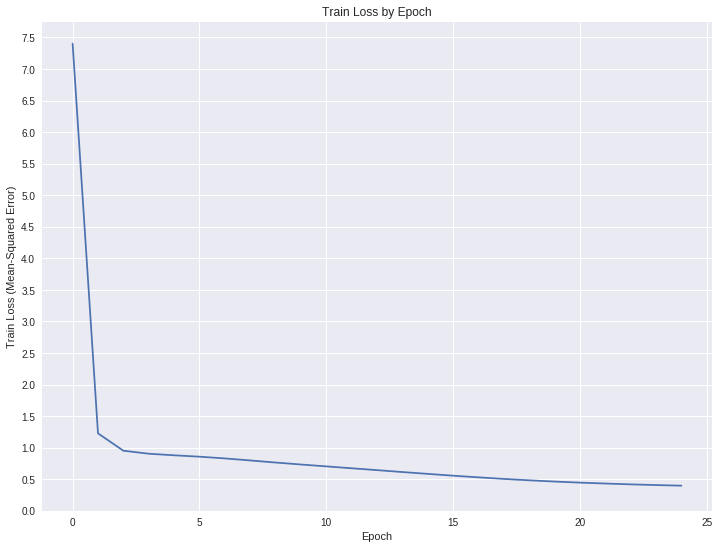

In [138]:
plt.rcParams['figure.figsize'] = 12, 9

plt.title('Train Loss by Epoch')

pd.Series(collab_bias_history.history['loss']).plot()
plt.yticks(np.arange(0, 8, 0.5))
plt.xlabel('Epoch')
plt.ylabel('Train Loss (Mean-Squared Error)')
plt.show()

In [139]:
y_pred = collab_bias_model.predict([test.userId, test.movieId])
y_pred_rounded = np.round(collab_bias_model.predict([test.userId, test.movieId]), 0)
y_true = test.rating

print(np.sqrt(mse(y_true, y_pred)))
print(np.sqrt(mse(y_true, y_pred_rounded)))

1.0091296036639237
1.051594028130628


Adding bias terms for movies and users didn't seem to have much of an effect on the loss. We're going to try one last Keras model, this time using a deep neural net based on Nipun Batra's model for collaborative filtering (see Sources).

### Deep Neural Network

#### DNN 1: Dropout: 0.1

In [0]:
n_latent_factors_user = 20
n_latent_factors_movie = 20

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie,
                                         name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.1)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1,
                                    n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.1)(user_vec)


concat = keras.layers.merge.concatenate([movie_vec, user_vec], axis=-1)
concat_dropout = keras.layers.Dropout(0.1)(concat)
dense = keras.layers.Dense(800,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.1,name='Dropout')(dense)
dense_2 = keras.layers.Dense(400,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.1,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(200,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.1,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(100,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
dnn_model = keras.Model([user_input, movie_input], result)
dnn_model.compile(optimizer='adam', loss= 'mean_squared_error')

In [0]:
SVG(model_to_dot(dnn_model, show_shapes=True, show_layer_names=True,
                 rankdir='HB').create(prog='dot', format='svg'))

keras.utils.plot_model(dnn_model,
              to_file='/content/drive/Colab Notebooks/ml-100k/keras_model3.png')

In [142]:
dnn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 20)        33660       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 20)        18880       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [143]:
dnn_history = dnn_model.fit([train.userId, train.movieId], train.rating,
                            epochs=25, verbose=1)

Epoch 1/25
80000/80000 [==============================] - 15s 188us/step - loss: 1.0651
Epoch 2/25
80000/80000 [==============================] - 14s 175us/step - loss: 0.9230
Epoch 3/25
80000/80000 [==============================] - 14s 176us/step - loss: 0.9072
Epoch 4/25
80000/80000 [==============================] - 14s 175us/step - loss: 0.8960
Epoch 5/25
80000/80000 [==============================] - 14s 175us/step - loss: 0.8898
Epoch 6/25
80000/80000 [==============================] - 14s 176us/step - loss: 0.8872
Epoch 7/25
80000/80000 [==============================] - 14s 173us/step - loss: 0.8808
Epoch 8/25
80000/80000 [==============================] - 14s 174us/step - loss: 0.8786
Epoch 9/25
80000/80000 [==============================] - 14s 173us/step - loss: 0.8733
Epoch 10/25
80000/80000 [==============================] - 14s 175us/step - loss: 0.8669
Epoch 11/25
80000/80000 [==============================] - 14s 174us/step - loss: 0.8539
Epoch 12/25
80000/80000 [=====

In [144]:
y_pred = dnn_model.predict([test.userId, test.movieId])
y_pred_rounded = np.round(dnn_model.predict([test.userId, test.movieId]))
y_true = test.rating

print(np.sqrt(mse(y_true, y_pred)))
print(np.sqrt(mse(y_true, y_pred_rounded)))

0.9286254379571606
0.9709531399609355


#### DNN 2: Dropout: 0.2

In [0]:
n_latent_factors_user = 20
n_latent_factors_movie = 20

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie,
                                         name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1,
                                    n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.merge.concatenate([movie_vec, user_vec], axis=-1)
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(800,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(400,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(200,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(100,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
dnn_model = keras.Model([user_input, movie_input], result)
dnn_model.compile(optimizer='adam', loss= 'mean_squared_error')

In [0]:
SVG(model_to_dot(dnn_model, show_shapes=True, show_layer_names=True,
                 rankdir='HB').create(prog='dot', format='svg'))

keras.utils.plot_model(dnn_model,
              to_file='/content/drive/Colab Notebooks/ml-100k/keras_model4.png')

In [147]:
dnn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 20)        33660       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 20)        18880       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [148]:
dnn_history = dnn_model.fit([train.userId, train.movieId], train.rating,
                            epochs=25, verbose=1)

Epoch 1/25
80000/80000 [==============================] - 15s 182us/step - loss: 1.0725
Epoch 2/25
80000/80000 [==============================] - 14s 175us/step - loss: 0.9284
Epoch 3/25
80000/80000 [==============================] - 14s 174us/step - loss: 0.9111
Epoch 4/25
80000/80000 [==============================] - 14s 175us/step - loss: 0.9032
Epoch 5/25
80000/80000 [==============================] - 14s 175us/step - loss: 0.8943
Epoch 6/25
80000/80000 [==============================] - 14s 175us/step - loss: 0.8850
Epoch 7/25
80000/80000 [==============================] - 14s 175us/step - loss: 0.8696
Epoch 8/25
80000/80000 [==============================] - 14s 176us/step - loss: 0.8599
Epoch 9/25
80000/80000 [==============================] - 14s 175us/step - loss: 0.8499
Epoch 10/25
80000/80000 [==============================] - 14s 175us/step - loss: 0.8410
Epoch 11/25
80000/80000 [==============================] - 14s 176us/step - loss: 0.8305
Epoch 12/25
80000/80000 [=====

In [149]:
y_pred = dnn_model.predict([test.userId, test.movieId])
y_pred_rounded = np.round(dnn_model.predict([test.userId, test.movieId]))
y_true = test.rating

print(np.sqrt(mse(y_true, y_pred)))
print(np.sqrt(mse(y_true, y_pred_rounded)))

0.9154027071337236
0.960780932366999


#### DNN 3: Dropout: 0.3

In [0]:
n_latent_factors_user = 20
n_latent_factors_movie = 20

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie,
                                         name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.3)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1,
                                    n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.3)(user_vec)


concat = keras.layers.merge.concatenate([movie_vec, user_vec], axis=-1)
concat_dropout = keras.layers.Dropout(0.3)(concat)
dense = keras.layers.Dense(800,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.3,name='Dropout')(dense)
dense_2 = keras.layers.Dense(400,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.3,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(200,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.3,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(100,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
dnn_model = keras.Model([user_input, movie_input], result)
dnn_model.compile(optimizer='adam', loss= 'mean_squared_error')

In [0]:
SVG(model_to_dot(dnn_model, show_shapes=True, show_layer_names=True,
                 rankdir='HB').create(prog='dot', format='svg'))

keras.utils.plot_model(dnn_model,
              to_file='/content/drive/Colab Notebooks/ml-100k/keras_model4.png')

In [152]:
dnn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 20)        33660       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 20)        18880       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [153]:
dnn_history = dnn_model.fit([train.userId, train.movieId], train.rating,
                            epochs=25, verbose=1)

Epoch 1/25
80000/80000 [==============================] - 15s 182us/step - loss: 1.0834
Epoch 2/25
80000/80000 [==============================] - 14s 175us/step - loss: 0.9352
Epoch 3/25
80000/80000 [==============================] - 14s 175us/step - loss: 0.9171
Epoch 4/25
80000/80000 [==============================] - 14s 175us/step - loss: 0.9078
Epoch 5/25
80000/80000 [==============================] - 14s 175us/step - loss: 0.8982
Epoch 6/25
80000/80000 [==============================] - 14s 177us/step - loss: 0.8946
Epoch 7/25
80000/80000 [==============================] - 14s 177us/step - loss: 0.8885
Epoch 8/25
80000/80000 [==============================] - 14s 176us/step - loss: 0.8764
Epoch 9/25
80000/80000 [==============================] - 14s 175us/step - loss: 0.8690
Epoch 10/25
80000/80000 [==============================] - 14s 176us/step - loss: 0.8611
Epoch 11/25
80000/80000 [==============================] - 14s 178us/step - loss: 0.8552
Epoch 12/25
80000/80000 [=====

In [154]:
y_pred = dnn_model.predict([test.userId, test.movieId])
y_pred_rounded = np.round(dnn_model.predict([test.userId, test.movieId]))
y_true = test.rating

print(np.sqrt(mse(y_true, y_pred)))
print(np.sqrt(mse(y_true, y_pred_rounded)))

0.9222959727389567
0.9645206063117574


These scores look much better than the other Keras model's scores! However, the loss is still higher than the librec benchmark.

# Conclusion

The fastai library had the best performance for the amount of effort required to use it, but none of the matrix factorization methods outperformed random forest regression on engineered features. We achieved our lowest cross-validated error score of 0.717 with a random forest regression with 150 estimators.

This model is somewhat computationally expensive, but the result is significantly lower than the librec.net benchmark of 0.911, and the next lowest error score we were able to achieve (fast.ai with a learning rate of 0.005, momentums of 0.95 and 0.7, and 30 latent factors) achieved a score barely lower than the benchmark, 0.906.

Problems with more limited available data might be better solved through use of neural net models, but given the categorical information included in the MovieLens 100k dataset, we were better off implementing a model that could take advantage of those preexisting categories.

# Implementation/Expandability

Using the random forest model, it is a fairly simple matter to take a subset of those movies with the highest-predicted ratings and to recommend that subset to the user. Although we rounded the scores to determine the loss for our models, we could use unrounded regression scores to determine predicted ranking with more granularity.

Assuming this algorithm is going to be implemented for a movie streaming service, we could also gather implicit rating information from a combination of user behavior, such as whether a user watched the entirety of a movie or just the first few minutes, or whether a user watched the movie more than once.

To solve the aforementioned "cold start" problem, there are a number of approaches that may work. For new users, it would be possible to have them complete a short survey about movies they had seen and liked in order to jump-start the process of recommendation. When providing the list of recommended movies to a user, it would also be possible to seed the list of recommendations with movies that have few ratings, in hopes of obtaining more information about those movies.

The random forest model would likely be better at the outset, but continuing to maintain it by recomputing mean ratings, genre proprotions, etc. each time a user watches another movie, would likely prove difficult. As user base and movie catalog grow, it would become more computationally complex to compute these values, and it might be better to use either a random sample of the data to compute them, or to switch to a neural net model.

# Sources


MovieLens 100k dataset:

https://grouplens.org/datasets/movielens/


MovieLens 100k dataset on Kaggle:

https://www.kaggle.com/prajitdatta/movielens-100k-dataset


Prince Grover's article on collaborative filtering methods, covering memory-based and model-based approaches:

https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0


fast.ai lessons on collaborative filtering, with matrix factorization in Microsoft Excel:

https://course.fast.ai/videos/?lesson=4

https://course.fast.ai/videos/?lesson=5


fast.ai changes:

https://github.com/fastai/fastai/search?q=pct_val&unscoped_q=pct_val


Nipun Batra's Keras models (shallow and deep neural networks):

https://nipunbatra.github.io/blog/2017/recommend-keras.html


Will Wolf's Keras models (adding a bias term to CF):

http://willwolf.io/2017/04/07/approximating-implicit-matrix-factorization-with-shallow-neural-networks/


MAE vs. RMSE as loss function:

https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d


JJ Espinoza on how collaborative filtering is used in the entertainment industry (tailored movie trailers!):

https://twimlai.com/twiml-talk-220-building-a-recommender-system-from-scratch-at-20th-century-fox-with-jj-espinoza/


Vishakha Lall on the basics of Google Colab:

https://medium.com/lean-in-women-in-tech-india/google-colab-the-beginners-guide-5ad3b417dfa


